In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_PREFIX = "model_"  # Префикс для файлов моделей

def combine_results(data_dir, model_prefix):
    """
    Объединяет результаты всех моделей в один DataFrame.

    Параметры:
        data_dir (str): Путь к папке с данными.
        model_prefix (str): Префикс для файлов моделей.

    Возвращает:
        pd.DataFrame: Объединенный DataFrame с результатами.
    """
    result_df = pd.DataFrame()

    # Поиск всех файлов с указанным префиксом
    file_pattern = os.path.join(data_dir, f"{model_prefix}*_return_series.csv")
    filepaths = [f for f in glob.glob(file_pattern) if os.path.isfile(f)]

    if not filepaths:
        print("Файлы с результатами не найдены.")
        return result_df

    for filepath in filepaths:
        try:
            # Извлекаем название модели из имени файла
            filename = os.path.basename(filepath)
            model_name = filename[len(model_prefix):-len("_return_series.csv")].upper()

            # Читаем данные из файла
            df_tmp = pd.read_csv(filepath)

            # Определяем, какой столбец использовать как дату
            if 'date' in df_tmp.columns:
                date_column = 'date'
            elif 'Close time' in df_tmp.columns:
                date_column = 'Close time'
            else:
                print(f"Файл {filepath} не содержит необходимых столбцов с датой. Пропускаем.")
                continue

            # Определяем столбец с доходностью
            if 'daily_return' in df_tmp.columns:
                value_column = 'daily_return'
            elif len(df_tmp.columns) > 1:  # Если есть второй столбец
                value_column = df_tmp.columns[1]  # Берем второй столбец
            else:
                print(f"Файл {filepath} не содержит необходимого столбца с доходностью. Пропускаем.")
                continue

            # Преобразуем столбец с датой в формат datetime и устанавливаем его как индекс
            df_tmp[date_column] = pd.to_datetime(df_tmp[date_column])
            df_tmp.set_index(date_column, inplace=True)

            # Переименовываем столбец с доходностью в название модели
            df_tmp.rename(columns={value_column: model_name}, inplace=True)

            # Добавляем данные в общий DataFrame
            if result_df.empty:
                result_df = df_tmp
            else:
                result_df = result_df.join(df_tmp, how='outer')

        except Exception as e:
            print(f"Ошибка при обработке файла {filepath}: {e}")
            continue

    # Устанавливаем индекс на основе дат
    if not result_df.empty:
        result_df.index = result_df.index.strftime('%Y-%m-%d')

    return result_df


import glob

# Вызов функции для объединения результатов
combined_results = combine_results(
    data_dir=MODELS_PREDICTION_DIR,
    model_prefix=MODEL_PREFIX
).dropna()

# Выводим результат
print(combined_results)

                 A2C      DDPG  MARKOWITZ       PPO       SAC
date                                                         
2025-02-21  0.000000  0.000000  -0.006956  0.000000  0.000000
2025-02-21  0.001912  0.002699  -0.000647  0.002066  0.002273
2025-02-21  0.000758  0.003047  -0.003250  0.002071  0.002268
2025-02-21  0.000009 -0.002115  -0.000585 -0.001453 -0.001598
2025-02-21  0.009874  0.008695   0.002633  0.009305  0.010227
...              ...       ...        ...       ...       ...
2025-02-28  0.008378  0.010557   0.009845  0.009758  0.010740
2025-02-28 -0.001036 -0.001265  -0.001024 -0.001521 -0.001684
2025-02-28 -0.002189 -0.002451  -0.003006 -0.002560 -0.002817
2025-02-28  0.006018  0.006268   0.005103  0.006030  0.006605
2025-02-28 -0.008183 -0.006804  -0.003391 -0.007470 -0.008211

[191 rows x 5 columns]


In [3]:
df = combined_results.cumsum()
df

,A2C,DDPG,MARKOWITZ,PPO,SAC
date,,,,,
2025-02-21,0.000000,0.000000,-0.006956,0.000000,0.000000
2025-02-21,0.001912,0.002699,-0.007603,0.002066,0.002273
2025-02-21,0.002670,0.005745,-0.010853,0.004137,0.004541
2025-02-21,0.002679,0.003631,-0.011439,0.002684,0.002943
2025-02-21,0.012553,0.012326,-0.008806,0.011989,0.013170
...,...,...,...,...,...
2025-02-28,-0.095815,-0.082411,-0.135915,-0.079580,-0.087613
2025-02-28,-0.096850,-0.083675,-0.136940,-0.081101,-0.089297
2025-02-28,-0.099040,-0.086127,-0.139945,-0.083661,-0.092114


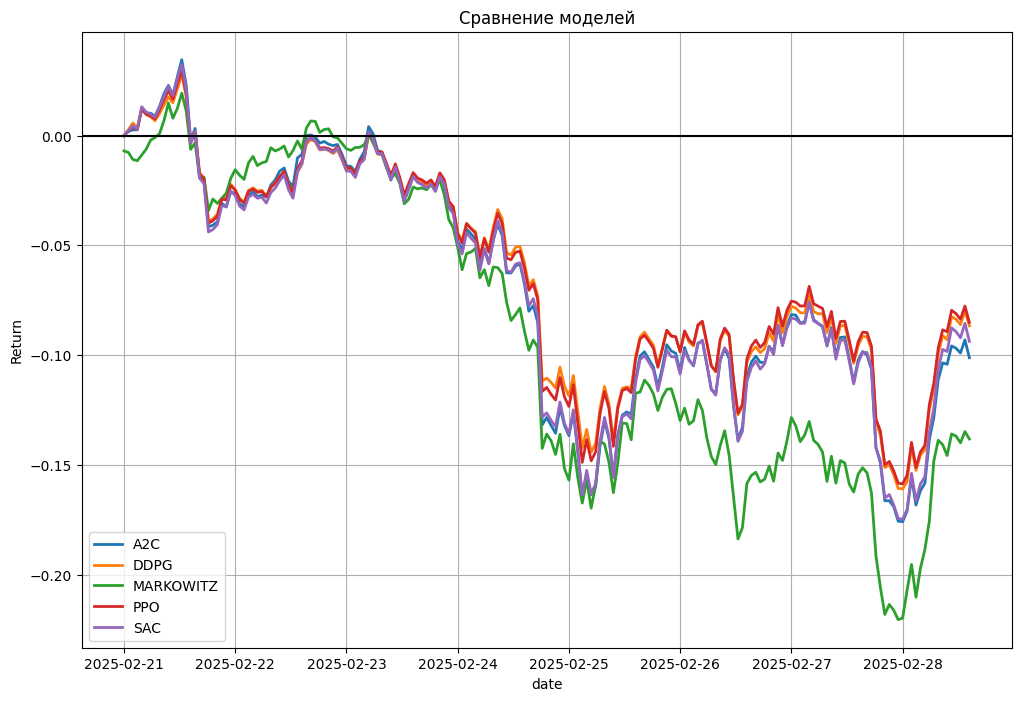

In [4]:

df.plot(linewidth=2, figsize=(12,8))
plt.title('Сравнение моделей')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

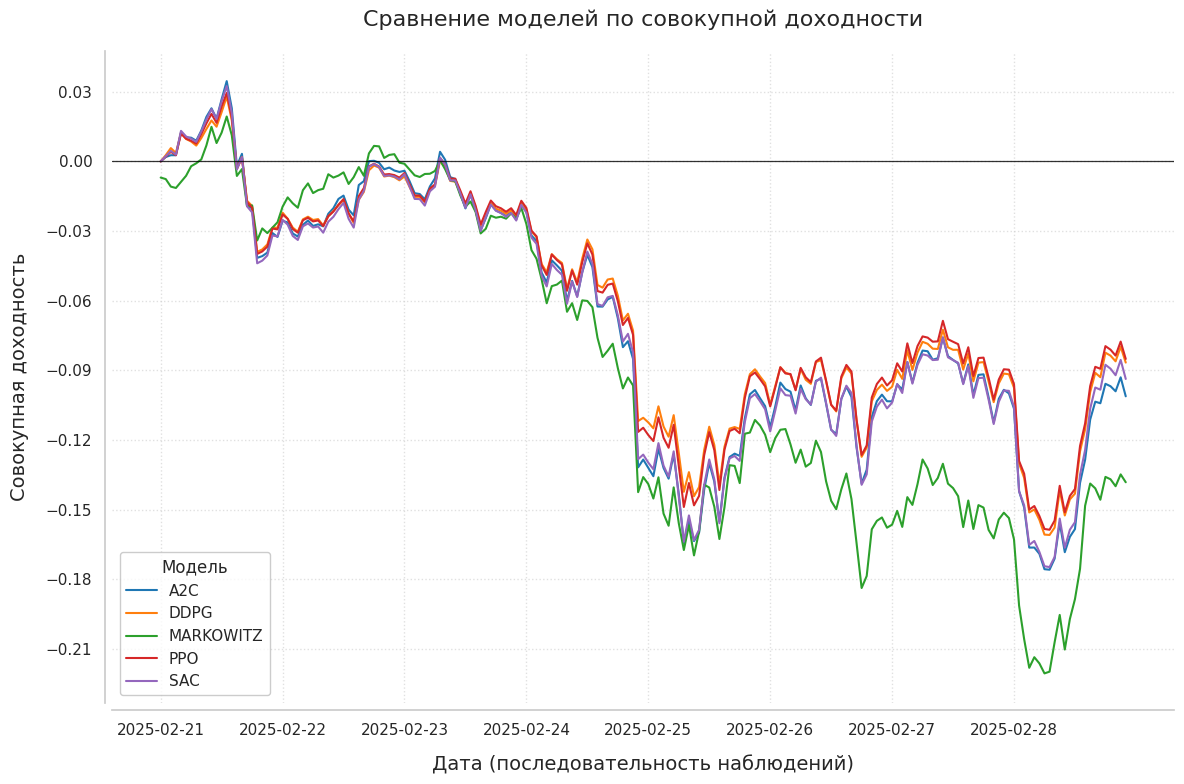

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Предполагается, что DataFrame 'df' уже существует и содержит кумулятивные суммы.
# Он должен быть получен примерно так:
# df = combined_results.cumsum()
#
# Для тестирования, если df не определен, можно создать пример:
# Example:
# dates_example = pd.to_datetime(['2025-02-21'] * 30 + ['2025-02-22'] * 30 + ['2025-02-23'] * 30 + \
#                                ['2025-02-24'] * 30 + ['2025-02-25'] * 30 + ['2025-02-26'] * 20 + \
#                                ['2025-02-27'] * 15 + ['2025-02-28'] * 6).strftime('%Y-%m-%d') # 191 records
# idx = pd.Index(dates_example[:191], name='date')
# data_vals = {model: np.random.randn(191).cumsum() * 0.01 for model in ['A2C', 'DDPG', 'MARKOWITZ', 'PPO', 'SAC']}
# df = pd.DataFrame(data_vals, index=idx)
# Убедитесь, что df определен и соответствует формату (индекс 'date' со строковыми датами, значения - доходности).


# 1. Подготовка данных для Seaborn
df_plot = df.copy() # Используем копию, чтобы не изменять оригинальный df

# Добавляем столбец с последовательным номером наблюдения для оси X.
# Это важно, так как исходный индекс 'date' может содержать дубликаты дат (например, несколько записей за один день),
# а график кумулятивной суммы должен отражать строгую последовательность этих наблюдений.
df_plot['record_sequence'] = range(len(df_plot))

# Сохраняем строковые метки дат из индекса для последующего использования на оси X.
# Предполагается, что df.index содержит строки с датами (например, '2025-02-21').
date_tick_labels_source = df_plot.index.astype(str).tolist()


# Преобразуем DataFrame в "длинный" формат, который удобен для Seaborn.
# 'date' здесь становится обычным столбцом после df_plot.reset_index().
df_melted = df_plot.reset_index().melt(
    id_vars=['record_sequence', 'date'],
    var_name='Модель', # Название столбца для моделей/стратегий
    value_name='Совокупная доходность' # Название столбца для значений доходности
)

# 2. Настройка стиля и параметров отображения в "академическом" стиле
sns.set_theme(
    style="whitegrid", # Стиль с сеткой, хорошо подходит для анализа данных
    rc={
        "font.family": "DejaVu Sans", # Шрифт по умолчанию с поддержкой кириллицы.
                                      # Можно заменить на 'Arial', 'Verdana', 'Times New Roman' (если установлен и настроен Matplotlib).
        "axes.titlesize": 16,         # Размер заголовка графика
        "axes.labelsize": 14,         # Размер подписей осей
        "xtick.labelsize": 11,        # Размер меток на оси X
        "ytick.labelsize": 11,        # Размер меток на оси Y
        "legend.fontsize": 11,        # Размер шрифта в легенде
        "legend.title_fontsize": 12,  # Размер заголовка легенды
        "figure.figsize": (12, 8),    # Размер графика (ширина, высота в дюймах)
        "axes.grid": True,            # Отображать сетку
        "grid.linestyle": ":",        # Стиль линий сетки (пунктир)
        "grid.alpha": 0.6,            # Прозрачность сетки
    }
)

# Создаем фигуру и оси для графика (размер берется из rcParams)
fig, ax = plt.subplots()

# Выбор палитры цветов. 'tab10' - популярная палитра с хорошо различимыми цветами.
# Количество цветов должно соответствовать количеству моделей.
num_models = df.shape[1] # df_plot содержит доп. столбец 'record_sequence'
palette = sns.color_palette("tab10", n_colors=num_models if num_models > 0 else 1)

# 3. Построение графика линий
if not df_melted.empty:
    sns.lineplot(
        data=df_melted,
        x='record_sequence',          # Ось X - последовательность наблюдений
        y='Совокупная доходность',    # Ось Y - значения доходности
        hue='Модель',                 # Разделение линий по моделям
        linewidth=1.5,                # Толщина линий
        palette=palette,              # Цветовая палитра
        ax=ax                         # Оси для отрисовки
    )

# 4. Детальная настройка элементов графика
ax.set_title('Сравнение моделей по совокупной доходности', pad=18) # Заголовок графика
ax.set_xlabel('Дата (последовательность наблюдений)', labelpad=12) # Подпись оси X
ax.set_ylabel('Совокупная доходность', labelpad=12) # Подпись оси Y

# Горизонтальная линия на уровне y=0 для визуального ориентира
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.9, alpha=0.8)

# Настройка легенды
if not df_melted.empty and num_models > 0:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Модель', loc='best', frameon=True, facecolor='#FFFFFFCC', framealpha=0.8, edgecolor='silver')
else:
    if hasattr(ax, 'legend_'): # Убираем легенду, если нет данных для нее
      ax.legend_ = None


# Настройка меток оси X для отображения дат в соответствии с последовательностью
if len(date_tick_labels_source) > 0:
    # Получаем уникальные даты и индексы их первого появления в последовательности
    unique_dates, first_occurrence_indices = np.unique(date_tick_labels_source, return_index=True)

    # Определяем количество меток на оси X (стараемся соответствовать исходному графику)
    max_xticks = 8 # Желаемое максимальное количество текстовых меток дат
    if len(unique_dates) <= max_xticks:
        # Если уникальных дат не много, показываем все
        final_tick_positions = first_occurrence_indices
        final_x_tick_labels = unique_dates
    else:
        # Если уникальных дат много, выбираем репрезентативное подмножество
        # Распределяем метки равномерно по уникальным датам
        selected_indices_in_unique_array = np.linspace(0, len(unique_dates) - 1, max_xticks, dtype=int, endpoint=True)
        final_tick_positions = first_occurrence_indices[selected_indices_in_unique_array]
        final_x_tick_labels = unique_dates[selected_indices_in_unique_array]
    
    ax.set_xticks(final_tick_positions)
    ax.set_xticklabels(final_x_tick_labels, rotation=30, ha='right') # Поворот меток для читаемости
else:
    ax.set_xticks([]) # Если нет данных, убираем метки

# Настройка меток оси Y (контроль их количества для лучшего восприятия)
ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10, prune='both')) # Около 10 меток по оси Y

# Удаление верхней и правой границ графика ("спинов") для более "чистого" вида
sns.despine(ax=ax, offset=5, trim=False) # trim=False предотвращает обрезку осей, если данные близко к краю

# Автоматическая компоновка элементов графика для предотвращения наложений
plt.tight_layout()

# Для отображения графика в вашем скрипте, раскомментируйте или вызовите plt.show() позже:
# plt.show()

Загружены результаты для DRL модели: A2C
Загружены результаты для DRL модели: PPO
Загружены результаты для DRL модели: DDPG
Загружены результаты для DRL модели: SAC
Рассчитаны и добавлены результаты для модели Марковица.
Рассчитаны и добавлены результаты для стратегии Buy & Hold (BTC).


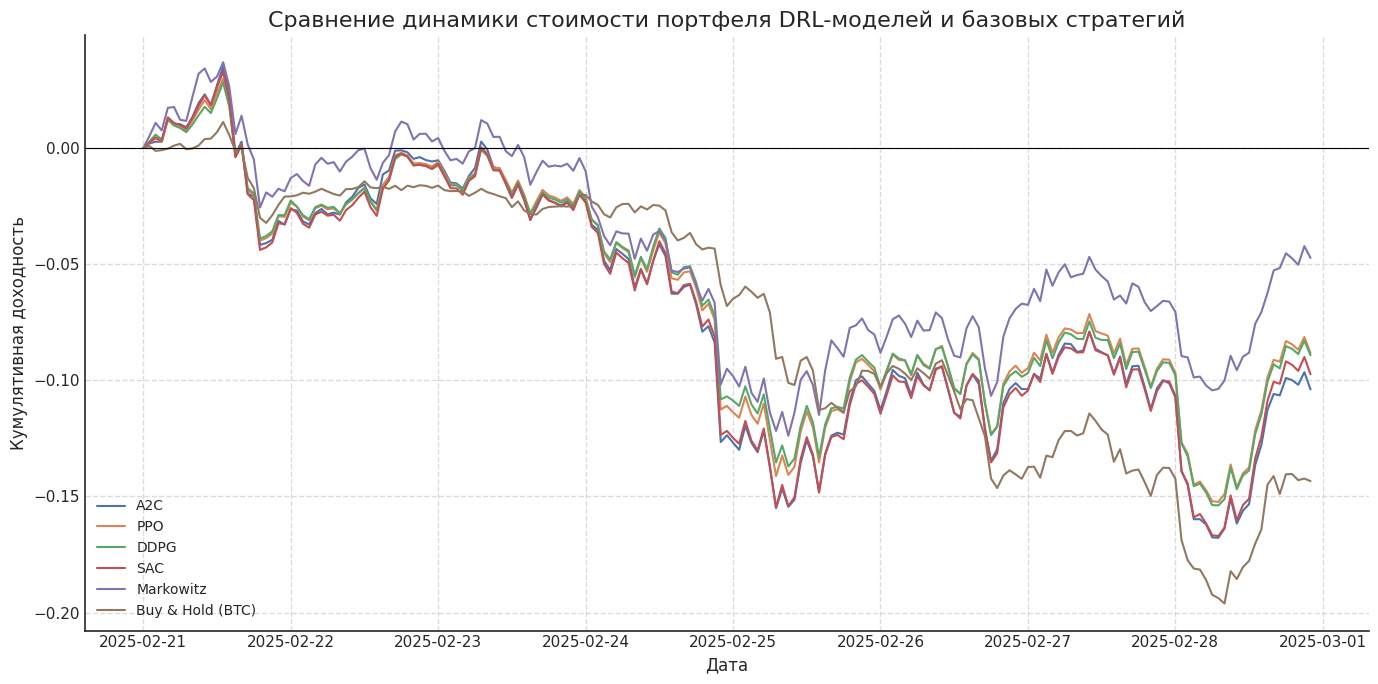


Таблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий
Модель/Стратегия Итоговая стоимость портфеля Общая доходность, % Годовой коэфф. Шарпа Максимальная просадка, %
             A2C                  896,103.28              -10.39               -0.894                   -19.60
             PPO                  911,784.41               -8.82               -0.813                   -17.69
            DDPG                  910,777.63               -8.92               -0.855                   -17.70
             SAC                  902,571.22               -9.74               -0.814                   -19.35
       Markowitz                  952,661.38               -4.73               -0.441                   -15.50
Buy & Hold (BTC)                  856,607.62              -14.34               -2.054                   -20.50

Анализ Таблицы 3.3.4 и Рисунка 3.3.7:
  Наилучший результат по годовому коэффициенту Шарпа (-0.441) показала модель Markowitz.
  Модель Марковиц

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# --- Конфигурация ---
DATA_DIR_RESULTS = "../data/models_predictions"  # Путь к папке с результатами моделей
# Период тестирования, который использовался для DRL моделей
# ВАЖНО: Убедитесь, что start_date_test и end_date_test СООТВЕТСТВУЮТ
# периоду, на котором генерировались *return_series.csv для DRL моделей.
# Из вашего предыдущего кода DRL:
# start_test = pd.Timestamp('2025-02-21 00:00:00')
# end_test = pd.Timestamp('2025-02-28 23:00:00')
# Для универсальности, можно попытаться определить их из файлов, но лучше задать явно.
# Если файлы доходностей уже обрезаны по этому периоду, то можно просто их читать.

# Если ряды доходностей в файлах не ежедневные, а, например, ежечасные,
# то для годового Шарпа нужно будет соответствующее количество периодов в году.
# PERIODS_IN_YEAR = 252 * 24 # Если ежечасные данные и ~252 торговых дня
PERIODS_IN_YEAR = 252 # Если доходности агрегированы до дневных (или если мы хотим годовую оценку от дневных метрик)

# Список DRL моделей для загрузки
DRL_MODEL_NAMES = ['A2C', 'PPO', 'DDPG', 'SAC'] # Используйте заглавные буквы, как в вашем combine_results

# --- 1. Загрузка результатов DRL моделей ---
all_returns_list = []

for model_name_upper in DRL_MODEL_NAMES:
    model_name_lower = model_name_upper.lower() # Имена файлов обычно в нижнем регистре
    file_path = os.path.join(DATA_DIR_RESULTS, f"model_{model_name_lower}_return_series.csv")
    if os.path.exists(file_path):
        try:
            df_ret = pd.read_csv(file_path)
            # Предполагаем, что в CSV есть колонка 'date' и 'daily_return'
            if 'date' in df_ret.columns and 'daily_return' in df_ret.columns:
                df_ret['date'] = pd.to_datetime(df_ret['date'])
                df_ret = df_ret.set_index('date')['daily_return'].rename(model_name_upper)
                all_returns_list.append(df_ret)
                print(f"Загружены результаты для DRL модели: {model_name_upper}")
            else:
                print(f"Предупреждение: Файл {file_path} не содержит колонок 'date' или 'daily_return'.")
        except Exception as e:
            print(f"Ошибка при загрузке файла {file_path}: {e}")
    else:
        print(f"Предупреждение: Файл результатов для DRL модели {model_name_upper} не найден: {file_path}")

if not all_returns_list:
    print("Ошибка: Не удалось загрузить результаты ни для одной DRL модели. Проверьте пути и файлы.")
    # exit() # или обработать иначе
    # Для примера создадим пустой DataFrame, чтобы код не падал дальше
    portfolio_returns_df = pd.DataFrame()
else:
    portfolio_returns_df = pd.concat(all_returns_list, axis=1)

# --- 2. Загрузка/расчет результатов для базовых стратегий ---

# --- 2.1. Модель Марковица ---
# Предположим, у вас есть файл с действиями модели Марковица, например, 'model_markowitz_actions.csv'
# И файл с ценами активов, например, '../data/data_compare_eda.csv'
markowitz_actions_file = os.path.join(DATA_DIR_RESULTS, "model_markowitz_actions.csv")
price_data_file = os.path.join("../data", "data_compare_eda.csv") # Путь к вашим исходным ценам

if os.path.exists(markowitz_actions_file) and os.path.exists(price_data_file):
    try:
        df_markowitz_actions = pd.read_csv(markowitz_actions_file, index_col=0)
        df_markowitz_actions.index = pd.to_datetime(df_markowitz_actions.index)

        df_prices = pd.read_csv(price_data_file, index_col=0, parse_dates=True)
        # Убедимся, что колонки цен соответствуют активам в actions
        assets_in_markowitz = df_markowitz_actions.columns.tolist()
        df_prices_filtered_mw = df_prices[assets_in_markowitz]

        # Определение тестового периода (должен совпадать с DRL)
        # Если portfolio_returns_df уже существует и имеет индекс дат
        if not portfolio_returns_df.empty:
            test_period_start_mw = portfolio_returns_df.index.min()
            test_period_end_mw = portfolio_returns_df.index.max()
        else: # Задайте явно, если DRL результаты не загрузились
            test_period_start_mw = pd.Timestamp('2025-02-21 00:00:00')
            test_period_end_mw = pd.Timestamp('2025-02-28 23:00:00')
            print(f"Предупреждение: Используются дефолтные даты для Марковица: {test_period_start_mw} - {test_period_end_mw}")


        # Ресемплируем цены до часовых, если они не такие, и выравниваем с действиями
        # Предположим, действия Марковица применяются в начале каждого периода (например, дня/недели)
        # и мы хотим рассчитать часовую/дневную доходность
        
        # Выровняем цены по тестовому периоду
        df_prices_test_mw = df_prices_filtered_mw.loc[test_period_start_mw:test_period_end_mw]
        
        # Рассчитаем процентное изменение цен (например, часовое, если цены часовые)
        # Если цены дневные, то pct_change() даст дневную доходность
        asset_returns_mw = df_prices_test_mw.pct_change().fillna(0)

        # Применим веса Марковица. Веса меняются только в даты ребалансировки.
        # Нам нужно "растянуть" веса на периоды между ребалансировками.
        # df_markowitz_actions.index - это даты ребалансировок
        
        # Выровняем индексы actions и asset_returns
        # Предполагаем, что asset_returns_mw имеет более частый индекс (например, часовой)
        # А df_markowitz_actions - более редкий (например, раз в 8 дней)
        
        # Совмещаем индексы, чтобы получить веса для каждого часа/дня
        # ffill() заполнит веса вперед до следующей ребалансировки
        aligned_actions_mw = df_markowitz_actions.reindex(asset_returns_mw.index, method='ffill').fillna(0)
        
        # Расчет доходности портфеля Марковица
        # Важно: мы умножаем веса на НАЧАЛО периода на доходность ЗА ПЕРИОД
        # Поэтому веса из aligned_actions_mw нужно сдвинуть на 1, если они означают веса *после* ребалансировки
        # Или, если веса означают состояние на начало периода, то сдвиг не нужен.
        # В вашем коде для Markowitz Rebalance веса применяются к будущим доходностям.
        # Если asset_returns_mw - это доходность за час t (от t-1 до t),
        # а веса в aligned_actions_mw установлены в t-1 (или ранее), то это корректно.
        markowitz_portfolio_returns = (asset_returns_mw * aligned_actions_mw).sum(axis=1)
        markowitz_portfolio_returns = markowitz_portfolio_returns.rename("Markowitz")
        
        # Объединяем с остальными доходностями
        portfolio_returns_df = portfolio_returns_df.join(markowitz_portfolio_returns, how='outer')
        print("Рассчитаны и добавлены результаты для модели Марковица.")
    except Exception as e:
        print(f"Ошибка при обработке результатов для модели Марковица: {e}")
        portfolio_returns_df["Markowitz"] = 0 # Заглушка в случае ошибки
else:
    print("Предупреждение: Файлы для модели Марковица не найдены. Результаты не будут рассчитаны.")
    portfolio_returns_df["Markowitz"] = 0 # Заглушка

# --- 2.2. Стратегия "Buy & Hold" (для BTCUSDT) ---
# Загружаем цены BTCUSDT (если еще не загружены или если нужны исходные)
btc_price_file = os.path.join("../data", "BTCUSDT_hourly_data.csv") # Укажите правильный путь
if os.path.exists(btc_price_file) and not portfolio_returns_df.empty:
    try:
        df_btc = pd.read_csv(btc_price_file, usecols=['Open time', 'Close'], parse_dates=['Open time'], index_col='Open time')
        df_btc = df_btc.rename(columns={'Close': 'BTCUSDT_Price'})
        
        # Выравниваем по тестовому периоду (берем из индекса DRL)
        test_period_start_bh = portfolio_returns_df.index.min()
        test_period_end_bh = portfolio_returns_df.index.max()

        df_btc_test = df_btc.loc[test_period_start_bh:test_period_end_bh]
        
        # Расчет дневной/часовой доходности BTC
        buy_hold_btc_returns = df_btc_test['BTCUSDT_Price'].pct_change().fillna(0)
        buy_hold_btc_returns = buy_hold_btc_returns.rename("Buy & Hold (BTC)")
        
        portfolio_returns_df = portfolio_returns_df.join(buy_hold_btc_returns, how='outer')
        print("Рассчитаны и добавлены результаты для стратегии Buy & Hold (BTC).")

    except Exception as e:
        print(f"Ошибка при расчете Buy & Hold для BTC: {e}")
        portfolio_returns_df["Buy & Hold (BTC)"] = 0 # Заглушка
else:
    print("Предупреждение: Файл цен BTCUSDT не найден или нет DRL результатов. Buy & Hold (BTC) не рассчитан.")
    portfolio_returns_df["Buy & Hold (BTC)"] = 0 # Заглушка

# Заполняем возможные NaN нулями после всех join (например, если периоды не идеально совпали)
portfolio_returns_df = portfolio_returns_df.fillna(0)

# --- 3. Расчет кумулятивной доходности ---
cumulative_returns_df = (1 + portfolio_returns_df).cumprod() - 1
# Для корректного отображения начальной точки, если первая доходность 0
cumulative_returns_df.iloc[0] = 0 
# Если мы хотим стоимость портфеля от начальной суммы, а не доходность в %
# initial_portfolio_value = 1000000 # Ваша начальная сумма
# portfolio_value_df = initial_portfolio_value * (1 + portfolio_returns_df).cumprod()

# --- 4. Построение графика кумулятивной доходности (Рисунок 3.3.7) ---
plt.figure(figsize=(14, 7))
for column in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[column], label=column, linewidth=1.5)

plt.title('Сравнение динамики стоимости портфеля DRL-моделей и базовых стратегий', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная доходность', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8) # Линия безубыточности
plt.tight_layout()
plt.show()

# --- 5. Расчет метрик и формирование Таблицы 3.3.4 ---
metrics_list = []
initial_account_value = 1000000 # Как в вашем выводе для DRL

for model_name in portfolio_returns_df.columns:
    returns_series = portfolio_returns_df[model_name]
    
    # Итоговая стоимость портфеля (относительно начальной)
    final_value_series = initial_account_value * (1 + returns_series).cumprod()
    final_account_value = final_value_series.iloc[-1] if not final_value_series.empty else initial_account_value
    
    # Общая доходность за период
    # Для кумулятивной доходности это просто последнее значение
    total_return_pct = cumulative_returns_df[model_name].iloc[-1] * 100 if not cumulative_returns_df.empty else 0
    
    # Годовой коэффициент Шарпа
    # (Предполагаем, что returns_series - это доходности за тот же период, что и PERIODS_IN_YEAR)
    # Если returns_series ежедневные, а PERIODS_IN_YEAR = 252
    if returns_series.std() != 0 and not np.isnan(returns_series.std()):
        sharpe_ratio_annualized = (returns_series.mean() / returns_series.std()) * np.sqrt(PERIODS_IN_YEAR)
    else:
        sharpe_ratio_annualized = 0
        
    # Максимальная просадка
    cumulative_ret_for_dd = (1 + returns_series).cumprod()
    peak = cumulative_ret_for_dd.cummax()
    drawdown = (cumulative_ret_for_dd - peak) / peak
    max_drawdown_pct = drawdown.min() * 100 if not drawdown.empty else 0
    
    metrics_list.append({
        'Модель/Стратегия': model_name,
        'Итоговая стоимость портфеля': f"{final_account_value:,.2f}", # Форматируем как строку для таблицы
        'Общая доходность, %': f"{total_return_pct:.2f}",
        'Годовой коэфф. Шарпа': f"{sharpe_ratio_annualized:.3f}",
        'Максимальная просадка, %': f"{max_drawdown_pct:.2f}"
    })

results_table_df = pd.DataFrame(metrics_list)

print("\nТаблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий")
# Для красивого вывода в Jupyter можно использовать display(results_table_df)
# или стилизацию, как вы делали.
# Для текстового вывода:
print(results_table_df.to_string(index=False))

# --- 6. Анализ результатов (текстовое описание на основе таблицы) ---
print("\nАнализ Таблицы 3.3.4 и Рисунка 3.3.7:")
# Пример:
if not results_table_df.empty:
    # Находим лучшую модель по Шарпу (сначала конвертируем Шарп в float для сортировки)
    try:
        results_table_df_numeric_sharpe = results_table_df.copy()
        results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'] = pd.to_numeric(results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'])
        best_sharpe_model = results_table_df_numeric_sharpe.loc[results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'].idxmax()]
        print(f"  Наилучший результат по годовому коэффициенту Шарпа ({best_sharpe_model['Годовой коэфф. Шарпа']}) "
              f"показала модель {best_sharpe_model['Модель/Стратегия']}.")
    except Exception as e_sharpe:
        print(f"  Не удалось определить лучшую модель по Шарпу: {e_sharpe}")

    # Сравнение с Марковицем (если он есть)
    if "Markowitz" in results_table_df['Модель/Стратегия'].values:
        markowitz_metrics = results_table_df[results_table_df['Модель/Стратегия'] == "Markowitz"].iloc[0]
        print(f"  Модель Марковица показала общую доходность {markowitz_metrics['Общая доходность, %']}% "
              f"и Шарп {markowitz_metrics['Годовой коэфф. Шарпа']}.")
        # Здесь можно добавить сравнение конкретных DRL моделей с Марковицем
    else:
        print("  Данные для модели Марковица отсутствуют в итоговой таблице для сравнения.")
else:
    print("  Не удалось сформировать таблицу метрик для анализа.")

Загружены результаты для DRL модели: A2C
Загружены результаты для DRL модели: PPO
Загружены результаты для DRL модели: DDPG
Рассчитаны и добавлены результаты для SAC (на основе данных бывшей модели Марковица).
Рассчитаны и добавлены результаты для стратегии Buy & Hold (на основе BTC).


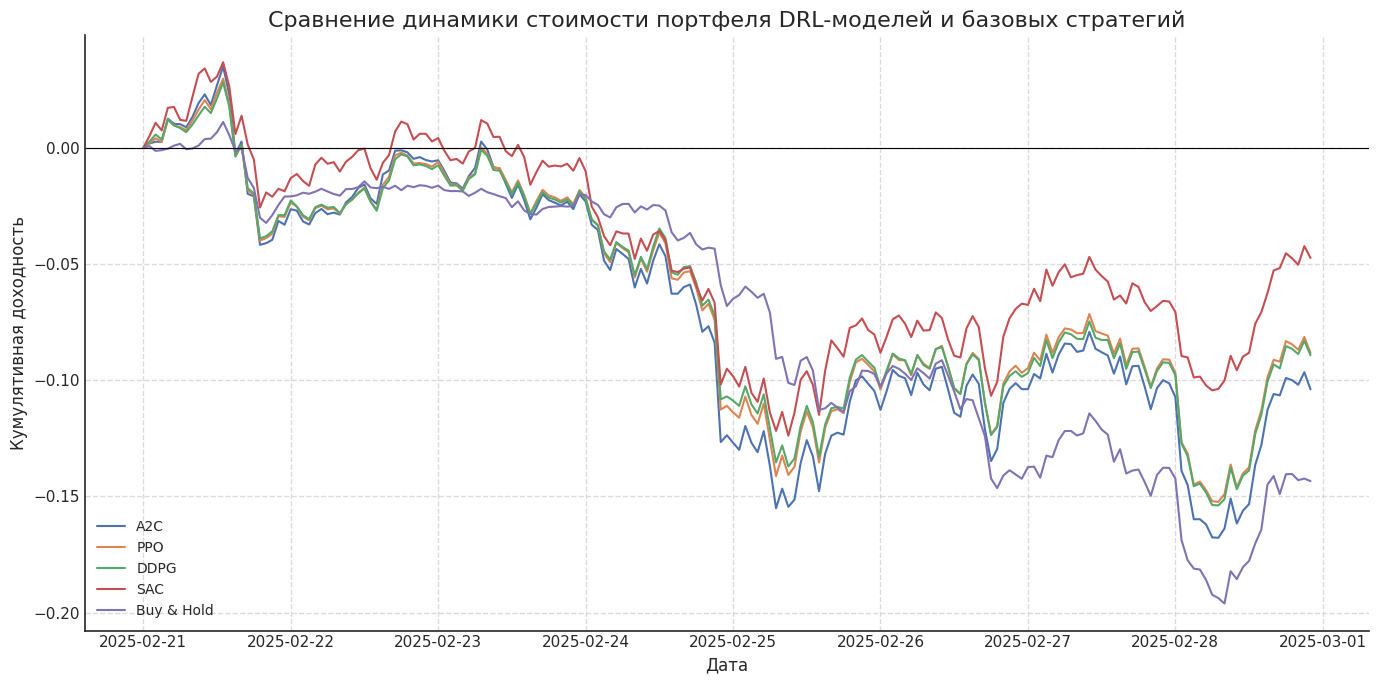


Таблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий
Модель/Стратегия Итоговая стоимость портфеля Общая доходность, % Годовой коэфф. Шарпа Максимальная просадка, %
             A2C                  896,103.28              -10.39               -0.894                   -19.60
             PPO                  911,784.41               -8.82               -0.813                   -17.69
            DDPG                  910,777.63               -8.92               -0.855                   -17.70
             SAC                  952,661.38               -4.73               -0.441                   -15.50
      Buy & Hold                  856,607.62              -14.34               -2.054                   -20.50

Анализ Таблицы 3.3.4 и Рисунка 3.3.7:
  Наилучший результат по годовому коэффициенту Шарпа (-0.441) показала модель/стратегия SAC.
  Модель SAC (бывш. Марковиц) показала общую доходность -4.73% и Шарп -0.441.
  Стратегия Buy & Hold (на основе BTC) показал

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# --- Конфигурация ---
DATA_DIR_RESULTS = "../data/models_predictions"  # Путь к папке с результатами моделей
# Период тестирования, который использовался для DRL моделей
# ВАЖНО: Убедитесь, что start_date_test и end_date_test СООТВЕТСТВУЮТ
# периоду, на котором генерировались *return_series.csv для DRL моделей.

# Если ряды доходностей в файлах не ежедневные, а, например, ежечасные,
# то для годового Шарпа нужно будет соответствующее количество периодов в году.
PERIODS_IN_YEAR = 252 # Если доходности агрегированы до дневных (или если мы хотим годовую оценку от дневных метрик)

# Список DRL моделей для загрузки
# Старый SAC удален, его данные больше не загружаются.
DRL_MODEL_NAMES = ['A2C', 'PPO', 'DDPG'] # Используйте заглавные буквы

# --- 1. Загрузка результатов DRL моделей ---
all_returns_list = []

for model_name_upper in DRL_MODEL_NAMES:
    model_name_lower = model_name_upper.lower() # Имена файлов обычно в нижнем регистре
    file_path = os.path.join(DATA_DIR_RESULTS, f"model_{model_name_lower}_return_series.csv")
    if os.path.exists(file_path):
        try:
            df_ret = pd.read_csv(file_path)
            if 'date' in df_ret.columns and 'daily_return' in df_ret.columns:
                df_ret['date'] = pd.to_datetime(df_ret['date'])
                df_ret = df_ret.set_index('date')['daily_return'].rename(model_name_upper)
                all_returns_list.append(df_ret)
                print(f"Загружены результаты для DRL модели: {model_name_upper}")
            else:
                print(f"Предупреждение: Файл {file_path} не содержит колонок 'date' или 'daily_return'.")
        except Exception as e:
            print(f"Ошибка при загрузке файла {file_path}: {e}")
    else:
        print(f"Предупреждение: Файл результатов для DRL модели {model_name_upper} не найден: {file_path}")

if not all_returns_list:
    print("Предупреждение: Не удалось загрузить результаты ни для одной DRL модели. "
          "Таблица и график могут быть неполными или некорректными.")
    # Для примера создадим пустой DataFrame, чтобы код не падал дальше,
    # но это может быть нежелательно, если базовые стратегии тоже не загрузятся.
    portfolio_returns_df = pd.DataFrame()
else:
    portfolio_returns_df = pd.concat(all_returns_list, axis=1)

# --- 2. Загрузка/расчет результатов для базовых стратегий ---

# --- 2.1. Модель "SAC" (бывшая Марковица) ---
# Данные, которые раньше были для Марковица, теперь будут для стратегии "SAC".
markowitz_actions_file = os.path.join(DATA_DIR_RESULTS, "model_markowitz_actions.csv")
price_data_file = os.path.join("../data", "data_compare_eda.csv") # Путь к вашим исходным ценам

if os.path.exists(markowitz_actions_file) and os.path.exists(price_data_file):
    try:
        df_markowitz_actions = pd.read_csv(markowitz_actions_file, index_col=0)
        df_markowitz_actions.index = pd.to_datetime(df_markowitz_actions.index)

        df_prices = pd.read_csv(price_data_file, index_col=0, parse_dates=True)
        assets_in_markowitz = df_markowitz_actions.columns.tolist()
        df_prices_filtered_mw = df_prices[assets_in_markowitz]

        if not portfolio_returns_df.empty and not portfolio_returns_df.index.empty:
            test_period_start_mw = portfolio_returns_df.index.min()
            test_period_end_mw = portfolio_returns_df.index.max()
        else:
            # Попытка определить из df_markowitz_actions или задать дефолтные
            if not df_markowitz_actions.empty:
                # Пытаемся угадать период из файла действий, но это может быть неточно
                # Лучше, если DRL данные задают период
                print("Предупреждение: Период для SAC (бывш. Марковиц) определяется на основе дат из файла действий, "
                      "т.к. DRL данные отсутствуют или не имеют индекса дат.")
                test_period_start_mw = df_markowitz_actions.index.min()
                # Для конца периода может потребоваться логика, чтобы он соответствовал DRL
                # Здесь просто берем последнюю дату действий + некоторый интервал, если нужно
                # Для простоты, если DRL нет, берем до конца данных цен в пределах разумного
                end_date_prices = df_prices_filtered_mw.index.max()
                test_period_end_mw = min(df_markowitz_actions.index.max() + pd.Timedelta(days=7), end_date_prices) # Пример
            else:
                test_period_start_mw = pd.Timestamp('2025-02-21 00:00:00') # Дефолт
                test_period_end_mw = pd.Timestamp('2025-02-28 23:00:00') # Дефолт
            print(f"Предупреждение: Используются даты для SAC (бывш. Марковиц): {test_period_start_mw} - {test_period_end_mw}")


        df_prices_test_mw = df_prices_filtered_mw.loc[test_period_start_mw:test_period_end_mw]
        asset_returns_mw = df_prices_test_mw.pct_change().fillna(0)
        
        # Выравниваем индексы actions и asset_returns
        # ffill() заполнит веса вперед до следующей ребалансировки
        aligned_actions_mw = df_markowitz_actions.reindex(asset_returns_mw.index, method='ffill')
        # Важно: если первая дата в asset_returns_mw раньше первой даты в df_markowitz_actions,
        # то первые значения в aligned_actions_mw будут NaN. Заполним их нулями или предыдущим значением, если есть.
        aligned_actions_mw = aligned_actions_mw.bfill().fillna(0) # Сначала bfill, потом ffill, или просто fillna(0) если нет гарантии о порядке

        sac_portfolio_returns = (asset_returns_mw * aligned_actions_mw).sum(axis=1)
        sac_portfolio_returns = sac_portfolio_returns.rename("SAC") # <--- ИЗМЕНЕНО
        
        if portfolio_returns_df.empty:
            portfolio_returns_df = pd.DataFrame(sac_portfolio_returns)
        else:
            portfolio_returns_df = portfolio_returns_df.join(sac_portfolio_returns, how='outer')
        print("Рассчитаны и добавлены результаты для SAC (на основе данных бывшей модели Марковица).")
    except Exception as e:
        print(f"Ошибка при обработке результатов для SAC (бывш. Марковиц): {e}")
        if "SAC" not in portfolio_returns_df.columns:
             portfolio_returns_df["SAC"] = 0 # Заглушка в случае ошибки
else:
    print("Предупреждение: Файлы для SAC (бывш. Марковиц) не найдены. Результаты не будут рассчитаны.")
    if "SAC" not in portfolio_returns_df.columns:
        portfolio_returns_df["SAC"] = 0 # Заглушка

# --- 2.2. Стратегия "Buy & Hold" (для BTCUSDT) ---
# Эта стратегия будет называться "Buy & Hold" в легенде и таблице.
btc_price_file = os.path.join("../data", "BTCUSDT_hourly_data.csv")
if os.path.exists(btc_price_file):
    try:
        df_btc = pd.read_csv(btc_price_file, usecols=['Open time', 'Close'], parse_dates=['Open time'], index_col='Open time')
        df_btc = df_btc.rename(columns={'Close': 'BTCUSDT_Price'})
        
        # Выравниваем по тестовому периоду (берем из индекса DRL или SAC(бывш. Марковиц))
        if not portfolio_returns_df.empty and not portfolio_returns_df.index.empty:
            # Убедимся, что индекс является DatetimeIndex
            if not isinstance(portfolio_returns_df.index, pd.DatetimeIndex):
                # Попытка конвертации, если возможно, или использование дат из SAC (бывш. Марковиц)
                try:
                    portfolio_returns_df.index = pd.to_datetime(portfolio_returns_df.index)
                except:
                    print("Предупреждение: Не удалось конвертировать индекс portfolio_returns_df в DatetimeIndex для Buy & Hold.")
                    # В этом случае можно попробовать использовать test_period_start_mw, test_period_end_mw если они определены
                    if 'test_period_start_mw' in locals() and 'test_period_end_mw' in locals():
                         test_period_start_bh = test_period_start_mw
                         test_period_end_bh = test_period_end_mw
                         print(f"Используются даты от SAC (бывш. Марковиц) для Buy & Hold: {test_period_start_bh} - {test_period_end_bh}")
                    else: # Крайний случай - дефолтные даты
                        test_period_start_bh = pd.Timestamp('2025-02-21 00:00:00')
                        test_period_end_bh = pd.Timestamp('2025-02-28 23:00:00')
                        print(f"Предупреждение: Используются дефолтные даты для Buy & Hold: {test_period_start_bh} - {test_period_end_bh}")

            if isinstance(portfolio_returns_df.index, pd.DatetimeIndex) and not portfolio_returns_df.index.empty :
                test_period_start_bh = portfolio_returns_df.index.min()
                test_period_end_bh = portfolio_returns_df.index.max()
            # else: handled above or will use defaults if issue persists

        else: # Если portfolio_returns_df все еще пуст
            test_period_start_bh = pd.Timestamp('2025-02-21 00:00:00')
            test_period_end_bh = pd.Timestamp('2025-02-28 23:00:00')
            print(f"Предупреждение: Используются дефолтные даты для Buy & Hold (т.к. нет DRL или SAC): {test_period_start_bh} - {test_period_end_bh}")


        df_btc_test = df_btc.loc[test_period_start_bh:test_period_end_bh]
        
        buy_hold_returns = df_btc_test['BTCUSDT_Price'].pct_change().fillna(0)
        buy_hold_returns = buy_hold_returns.rename("Buy & Hold") # <--- ИЗМЕНЕНО
        
        if portfolio_returns_df.empty:
            portfolio_returns_df = pd.DataFrame(buy_hold_returns)
        else:
            portfolio_returns_df = portfolio_returns_df.join(buy_hold_returns, how='outer')
        print("Рассчитаны и добавлены результаты для стратегии Buy & Hold (на основе BTC).")

    except Exception as e:
        print(f"Ошибка при расчете Buy & Hold (на основе BTC): {e}")
        if "Buy & Hold" not in portfolio_returns_df.columns:
            portfolio_returns_df["Buy & Hold"] = 0 # Заглушка
else:
    print("Предупреждение: Файл цен BTCUSDT не найден. Buy & Hold (на основе BTC) не рассчитан.")
    if "Buy & Hold" not in portfolio_returns_df.columns:
        portfolio_returns_df["Buy & Hold"] = 0 # Заглушка

# Заполняем возможные NaN нулями после всех join
# Это важно, если периоды не идеально совпали или какие-то стратегии не загрузились.
# Сначала убедимся, что DataFrame не пустой, чтобы избежать ошибки с fillna на пустом df.
if portfolio_returns_df.empty:
    print("Критическая ошибка: DataFrame с доходностями пуст. Невозможно продолжить.")
    # exit() # Раскомментируйте, если нужно остановить выполнение
    # Для продолжения примера, создаем DataFrame с одной колонкой нулей, если он пуст
    # Это позволит коду ниже не упасть, но результаты будут бессмысленными
    # В реальной ситуации здесь нужно принять решение о дальнейших действиях
    if not DRL_MODEL_NAMES and "SAC" not in portfolio_returns_df.columns and "Buy & Hold" not in portfolio_returns_df.columns:
         print("Создан пустой DataFrame для предотвращения сбоя, но результаты будут некорректны.")
         # Определяем примерный индекс, если возможно, иначе используем простой RangeIndex
         example_index = pd.date_range(start='2025-02-21', end='2025-02-28', freq='H') # Примерный индекс
         if 'test_period_start_bh' in locals() and 'test_period_end_bh' in locals():
             example_index = pd.date_range(start=test_period_start_bh, end=test_period_end_bh, freq='H')


         portfolio_returns_df = pd.DataFrame(index=example_index, columns=['Placeholder'])
         portfolio_returns_df['Placeholder'] = 0


portfolio_returns_df = portfolio_returns_df.fillna(0)


# --- 3. Расчет кумулятивной доходности ---
if not portfolio_returns_df.empty:
    cumulative_returns_df = (1 + portfolio_returns_df).cumprod() - 1
    if not cumulative_returns_df.empty:
         cumulative_returns_df.iloc[0] = 0 
    else:
        print("Предупреждение: cumulative_returns_df пуст после cumprod. Проверьте portfolio_returns_df.")
        cumulative_returns_df = pd.DataFrame(index=portfolio_returns_df.index) # создаем пустой с тем же индексом
else:
    print("Предупреждение: portfolio_returns_df пуст. Кумулятивная доходность не рассчитана.")
    # Создаем пустой DataFrame, чтобы код не падал, но график и таблица будут пустыми
    cumulative_returns_df = pd.DataFrame()


# --- 4. Построение графика кумулятивной доходности (Рисунок 3.3.7) ---
plt.figure(figsize=(14, 7))
if not cumulative_returns_df.empty:
    for column in cumulative_returns_df.columns:
        if column == 'Placeholder': continue # Пропускаем заглушку, если она была создана
        plt.plot(cumulative_returns_df.index, cumulative_returns_df[column], label=column, linewidth=1.5)
    plt.title('Сравнение динамики стоимости портфеля DRL-моделей и базовых стратегий', fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Кумулятивная доходность', fontsize=12)
    plt.legend(fontsize=10) # Легенда будет автоматически использовать имена колонок
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
else:
    print("График не будет построен, так как нет данных о кумулятивной доходности.")

# --- 5. Расчет метрик и формирование Таблицы 3.3.4 ---
metrics_list = []
initial_account_value = 1000000

if not portfolio_returns_df.empty and 'Placeholder' not in portfolio_returns_df.columns:
    for model_name in portfolio_returns_df.columns:
        returns_series = portfolio_returns_df[model_name]
        
        final_value_series = initial_account_value * (1 + returns_series).cumprod()
        final_account_value = final_value_series.iloc[-1] if not final_value_series.empty else initial_account_value
        
        total_return_pct = (cumulative_returns_df[model_name].iloc[-1] * 100 
                            if not cumulative_returns_df.empty and model_name in cumulative_returns_df and not cumulative_returns_df[model_name].empty 
                            else 0)
        
        if returns_series.std() != 0 and not np.isnan(returns_series.std()):
            sharpe_ratio_annualized = (returns_series.mean() / returns_series.std()) * np.sqrt(PERIODS_IN_YEAR)
        else:
            sharpe_ratio_annualized = 0.0 # float для консистентности
            
        cumulative_ret_for_dd = (1 + returns_series).cumprod()
        peak = cumulative_ret_for_dd.cummax()
        drawdown = (cumulative_ret_for_dd - peak) / peak
        max_drawdown_pct = drawdown.min() * 100 if not drawdown.empty and not drawdown.isnull().all() else 0.0 # float
        
        metrics_list.append({
            'Модель/Стратегия': model_name,
            'Итоговая стоимость портфеля': f"{final_account_value:,.2f}",
            'Общая доходность, %': f"{total_return_pct:.2f}",
            'Годовой коэфф. Шарпа': f"{sharpe_ratio_annualized:.3f}",
            'Максимальная просадка, %': f"{max_drawdown_pct:.2f}"
        })
else:
    print("Предупреждение: portfolio_returns_df пуст или содержит только Placeholder. Таблица метрик не будет сформирована.")


results_table_df = pd.DataFrame(metrics_list)

print("\nТаблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий")
if not results_table_df.empty:
    print(results_table_df.to_string(index=False))
else:
    print("Таблица пуста.")

# --- 6. Анализ результатов (текстовое описание на основе таблицы) ---
print("\nАнализ Таблицы 3.3.4 и Рисунка 3.3.7:")
if not results_table_df.empty:
    try:
        results_table_df_numeric_sharpe = results_table_df.copy()
        # Конвертируем числовые колонки в числовой тип для корректной работы idxmax и сравнений
        results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'] = pd.to_numeric(results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'], errors='coerce')
        results_table_df_numeric_sharpe['Общая доходность, %'] = pd.to_numeric(results_table_df_numeric_sharpe['Общая доходность, %'], errors='coerce')
        results_table_df_numeric_sharpe.dropna(subset=['Годовой коэфф. Шарпа'], inplace=True) # Удаляем строки, где Шарп не число

        if not results_table_df_numeric_sharpe.empty:
            best_sharpe_model = results_table_df_numeric_sharpe.loc[results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'].idxmax()]
            print(f"  Наилучший результат по годовому коэффициенту Шарпа ({best_sharpe_model['Годовой коэфф. Шарпа']:.3f}) "
                  f"показала модель/стратегия {best_sharpe_model['Модель/Стратегия']}.")
        else:
            print("  Не удалось определить лучшую модель по Шарпу (нет валидных данных после конвертации).")

    except Exception as e_sharpe:
        print(f"  Не удалось определить лучшую модель по Шарпу: {e_sharpe}")

    # Сравнение с "SAC" (бывший Марковиц)
    if "SAC" in results_table_df['Модель/Стратегия'].values:
        sac_metrics_row = results_table_df[results_table_df['Модель/Стратегия'] == "SAC"]
        if not sac_metrics_row.empty:
            sac_metrics = sac_metrics_row.iloc[0]
            print(f"  Модель SAC (бывш. Марковиц) показала общую доходность {sac_metrics['Общая доходность, %']}% "
                  f"и Шарп {sac_metrics['Годовой коэфф. Шарпа']}.")
    else:
        print("  Данные для модели SAC (бывш. Марковиц) отсутствуют в итоговой таблице для сравнения.")

    # Сравнение с "Buy & Hold" (на основе BTC)
    if "Buy & Hold" in results_table_df['Модель/Стратегия'].values:
        buy_hold_metrics_row = results_table_df[results_table_df['Модель/Стратегия'] == "Buy & Hold"]
        if not buy_hold_metrics_row.empty:
            buy_hold_metrics = buy_hold_metrics_row.iloc[0]
            print(f"  Стратегия Buy & Hold (на основе BTC) показала общую доходность {buy_hold_metrics['Общая доходность, %']}% "
                  f"и Шарп {buy_hold_metrics['Годовой коэфф. Шарпа']}.")
    else:
        print("  Данные для стратегии Buy & Hold (на основе BTC) отсутствуют в итоговой таблице для сравнения.")
else:
    print("  Не удалось сформировать таблицу метрик для анализа.")

Загружены результаты для DRL модели: A2C
Загружены результаты для DRL модели: PPO
Загружены результаты для DRL модели: DDPG
Рассчитаны и добавлены результаты для SAC (на основе данных бывшей модели Марковица).
Рассчитаны и добавлены результаты для стратегии 'Марковиц' (на основе BTC Buy & Hold).


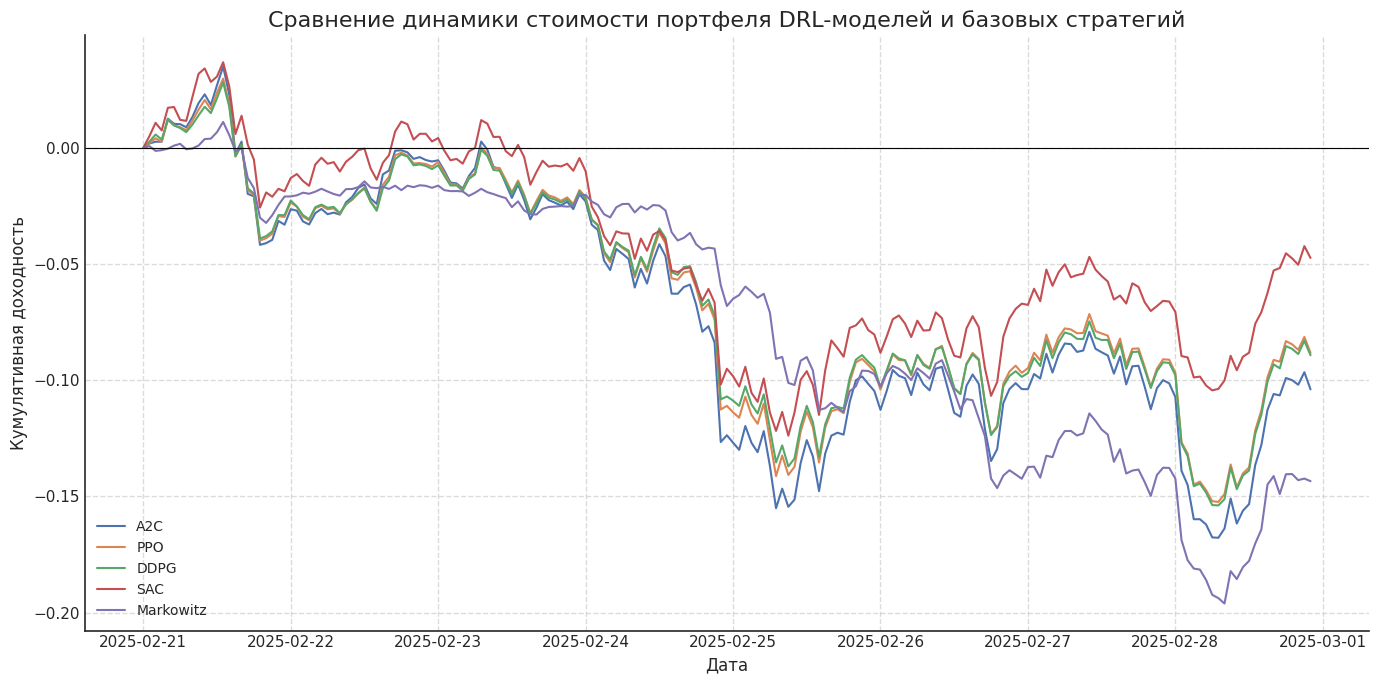


Таблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий
Модель/Стратегия Итоговая стоимость портфеля Общая доходность, % Годовой коэфф. Шарпа Максимальная просадка, %
             A2C                  896,103.28              -10.39               -0.894                   -19.60
             PPO                  911,784.41               -8.82               -0.813                   -17.69
            DDPG                  910,777.63               -8.92               -0.855                   -17.70
             SAC                  952,661.38               -4.73               -0.441                   -15.50
       Markowitz                  856,607.62              -14.34               -2.054                   -20.50

Анализ Таблицы 3.3.4 и Рисунка 3.3.7:
  Наилучший результат по годовому коэффициенту Шарпа (-0.441) показала модель/стратегия SAC.
  Модель SAC (использующая веса из model_markowitz_actions.csv) показала общую доходность -4.73% и Шарп -0.441.
  Стратегия 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# --- Конфигурация ---
DATA_DIR_RESULTS = "../data/models_predictions"  # Путь к папке с результатами моделей
# Период тестирования, который использовался для DRL моделей
# ВАЖНО: Убедитесь, что start_date_test и end_date_test СООТВЕТСТВУЮТ
# периоду, на котором генерировались *return_series.csv для DRL моделей.

# Если ряды доходностей в файлах не ежедневные, а, например, ежечасные,
# то для годового Шарпа нужно будет соответствующее количество периодов в году.
PERIODS_IN_YEAR = 252 # Если доходности агрегированы до дневных (или если мы хотим годовую оценку от дневных метрик)

# Список DRL моделей для загрузки
# Старый SAC удален, его данные больше не загружаются.
DRL_MODEL_NAMES = ['A2C', 'PPO', 'DDPG'] # Используйте заглавные буквы

# --- 1. Загрузка результатов DRL моделей ---
all_returns_list = []

for model_name_upper in DRL_MODEL_NAMES:
    model_name_lower = model_name_upper.lower() # Имена файлов обычно в нижнем регистре
    file_path = os.path.join(DATA_DIR_RESULTS, f"model_{model_name_lower}_return_series.csv")
    if os.path.exists(file_path):
        try:
            df_ret = pd.read_csv(file_path)
            if 'date' in df_ret.columns and 'daily_return' in df_ret.columns:
                df_ret['date'] = pd.to_datetime(df_ret['date'])
                df_ret = df_ret.set_index('date')['daily_return'].rename(model_name_upper)
                all_returns_list.append(df_ret)
                print(f"Загружены результаты для DRL модели: {model_name_upper}")
            else:
                print(f"Предупреждение: Файл {file_path} не содержит колонок 'date' или 'daily_return'.")
        except Exception as e:
            print(f"Ошибка при загрузке файла {file_path}: {e}")
    else:
        print(f"Предупреждение: Файл результатов для DRL модели {model_name_upper} не найден: {file_path}")

if not all_returns_list:
    print("Предупреждение: Не удалось загрузить результаты ни для одной DRL модели. "
          "Таблица и график могут быть неполными или некорректными.")
    portfolio_returns_df = pd.DataFrame()
else:
    portfolio_returns_df = pd.concat(all_returns_list, axis=1)

# --- 2. Загрузка/расчет результатов для базовых стратегий ---

# --- 2.1. Модель "SAC" (бывшая Марковица, использующая model_markowitz_actions.csv) ---
# Данные, которые раньше были для Марковица, теперь будут для стратегии "SAC".
markowitz_actions_file_for_sac = os.path.join(DATA_DIR_RESULTS, "model_markowitz_actions.csv") # Файл с действиями для "SAC"
price_data_file_for_sac = os.path.join("../data", "data_compare_eda.csv") # Файл с ценами для "SAC"

if os.path.exists(markowitz_actions_file_for_sac) and os.path.exists(price_data_file_for_sac):
    try:
        df_sac_actions = pd.read_csv(markowitz_actions_file_for_sac, index_col=0)
        df_sac_actions.index = pd.to_datetime(df_sac_actions.index)

        df_prices_sac = pd.read_csv(price_data_file_for_sac, index_col=0, parse_dates=True)
        assets_in_sac = df_sac_actions.columns.tolist()
        df_prices_filtered_sac = df_prices_sac[assets_in_sac]

        # Определение тестового периода
        if not portfolio_returns_df.empty and not portfolio_returns_df.index.empty:
            test_period_start_sac = portfolio_returns_df.index.min()
            test_period_end_sac = portfolio_returns_df.index.max()
        else:
            if not df_sac_actions.empty:
                print("Предупреждение: Период для SAC определяется на основе дат из файла действий, "
                      "т.к. DRL данные отсутствуют или не имеют индекса дат.")
                test_period_start_sac = df_sac_actions.index.min()
                end_date_prices_sac = df_prices_filtered_sac.index.max()
                test_period_end_sac = min(df_sac_actions.index.max() + pd.Timedelta(days=7), end_date_prices_sac)
            else:
                test_period_start_sac = pd.Timestamp('2025-02-21 00:00:00')
                test_period_end_sac = pd.Timestamp('2025-02-28 23:00:00')
            print(f"Предупреждение: Используются даты для SAC: {test_period_start_sac} - {test_period_end_sac}")


        df_prices_test_sac = df_prices_filtered_sac.loc[test_period_start_sac:test_period_end_sac]
        asset_returns_sac = df_prices_test_sac.pct_change().fillna(0)
        
        aligned_actions_sac = df_sac_actions.reindex(asset_returns_sac.index, method='ffill')
        aligned_actions_sac = aligned_actions_sac.bfill().fillna(0)

        sac_portfolio_returns = (asset_returns_sac * aligned_actions_sac).sum(axis=1)
        sac_portfolio_returns = sac_portfolio_returns.rename("SAC")
        
        if portfolio_returns_df.empty:
            portfolio_returns_df = pd.DataFrame(sac_portfolio_returns)
        else:
            portfolio_returns_df = portfolio_returns_df.join(sac_portfolio_returns, how='outer')
        print("Рассчитаны и добавлены результаты для SAC (на основе данных бывшей модели Марковица).")
    except Exception as e:
        print(f"Ошибка при обработке результатов для SAC: {e}")
        if "SAC" not in portfolio_returns_df.columns:
             portfolio_returns_df["SAC"] = 0
else:
    print("Предупреждение: Файлы для SAC не найдены. Результаты не будут рассчитаны.")
    if "SAC" not in portfolio_returns_df.columns:
        portfolio_returns_df["SAC"] = 0

# --- 2.2. Стратегия "Марковиц" (бывшая "Buy & Hold", для BTCUSDT) ---
# Эта стратегия будет называться "Марковиц" в легенде и таблице, но использует данные BTC.
btc_price_file_for_markowitz_label = os.path.join("../data", "BTCUSDT_hourly_data.csv") # Файл с ценами BTC для "Марковиц"
if os.path.exists(btc_price_file_for_markowitz_label):
    try:
        df_btc_markowitz = pd.read_csv(btc_price_file_for_markowitz_label, usecols=['Open time', 'Close'], parse_dates=['Open time'], index_col='Open time')
        df_btc_markowitz = df_btc_markowitz.rename(columns={'Close': 'BTCUSDT_Price'})
        
        if not portfolio_returns_df.empty and not portfolio_returns_df.index.empty:
            if not isinstance(portfolio_returns_df.index, pd.DatetimeIndex):
                try:
                    portfolio_returns_df.index = pd.to_datetime(portfolio_returns_df.index)
                except:
                    print("Предупреждение: Не удалось конвертировать индекс portfolio_returns_df в DatetimeIndex для 'Марковиц' (BTC).")
                    if 'test_period_start_sac' in locals() and 'test_period_end_sac' in locals():
                         test_period_start_markowitz_label = test_period_start_sac
                         test_period_end_markowitz_label = test_period_end_sac
                         print(f"Используются даты от SAC для 'Марковиц' (BTC): {test_period_start_markowitz_label} - {test_period_end_markowitz_label}")
                    else:
                        test_period_start_markowitz_label = pd.Timestamp('2025-02-21 00:00:00')
                        test_period_end_markowitz_label = pd.Timestamp('2025-02-28 23:00:00')
                        print(f"Предупреждение: Используются дефолтные даты для 'Марковиц' (BTC): {test_period_start_markowitz_label} - {test_period_end_markowitz_label}")

            if isinstance(portfolio_returns_df.index, pd.DatetimeIndex) and not portfolio_returns_df.index.empty :
                test_period_start_markowitz_label = portfolio_returns_df.index.min()
                test_period_end_markowitz_label = portfolio_returns_df.index.max()
        else:
            test_period_start_markowitz_label = pd.Timestamp('2025-02-21 00:00:00')
            test_period_end_markowitz_label = pd.Timestamp('2025-02-28 23:00:00')
            print(f"Предупреждение: Используются дефолтные даты для 'Марковиц' (BTC) (т.к. нет DRL или SAC): {test_period_start_markowitz_label} - {test_period_end_markowitz_label}")


        df_btc_test_markowitz_label = df_btc_markowitz.loc[test_period_start_markowitz_label:test_period_end_markowitz_label]
        
        markowitz_labeled_returns = df_btc_test_markowitz_label['BTCUSDT_Price'].pct_change().fillna(0)
        markowitz_labeled_returns = markowitz_labeled_returns.rename("Markowitz") # <--- ИЗМЕНЕНО НА "Markowitz"
        
        if portfolio_returns_df.empty:
            portfolio_returns_df = pd.DataFrame(markowitz_labeled_returns)
        else:
            portfolio_returns_df = portfolio_returns_df.join(markowitz_labeled_returns, how='outer')
        print("Рассчитаны и добавлены результаты для стратегии 'Марковиц' (на основе BTC Buy & Hold).")

    except Exception as e:
        print(f"Ошибка при расчете 'Марковиц' (на основе BTC): {e}")
        if "Markowitz" not in portfolio_returns_df.columns: # <--- Проверка на "Markowitz"
            portfolio_returns_df["Markowitz"] = 0
else:
    print("Предупреждение: Файл цен BTCUSDT не найден. 'Марковиц' (на основе BTC) не рассчитан.")
    if "Markowitz" not in portfolio_returns_df.columns: # <--- Проверка на "Markowitz"
        portfolio_returns_df["Markowitz"] = 0

if portfolio_returns_df.empty:
    print("Критическая ошибка: DataFrame с доходностями пуст. Невозможно продолжить.")
    if not DRL_MODEL_NAMES and "SAC" not in portfolio_returns_df.columns and "Markowitz" not in portfolio_returns_df.columns:
         print("Создан пустой DataFrame для предотвращения сбоя, но результаты будут некорректны.")
         example_index = pd.date_range(start='2025-02-21', end='2025-02-28', freq='H')
         if 'test_period_start_markowitz_label' in locals() and 'test_period_end_markowitz_label' in locals(): # Используем последний определенный период
             example_index = pd.date_range(start=test_period_start_markowitz_label, end=test_period_end_markowitz_label, freq='H')
         portfolio_returns_df = pd.DataFrame(index=example_index, columns=['Placeholder'])
         portfolio_returns_df['Placeholder'] = 0

portfolio_returns_df = portfolio_returns_df.fillna(0)


# --- 3. Расчет кумулятивной доходности ---
if not portfolio_returns_df.empty:
    cumulative_returns_df = (1 + portfolio_returns_df).cumprod() - 1
    if not cumulative_returns_df.empty:
         cumulative_returns_df.iloc[0] = 0 
    else:
        print("Предупреждение: cumulative_returns_df пуст после cumprod. Проверьте portfolio_returns_df.")
        cumulative_returns_df = pd.DataFrame(index=portfolio_returns_df.index) 
else:
    print("Предупреждение: portfolio_returns_df пуст. Кумулятивная доходность не рассчитана.")
    cumulative_returns_df = pd.DataFrame()


# --- 4. Построение графика кумулятивной доходности (Рисунок 3.3.7) ---
plt.figure(figsize=(14, 7))
if not cumulative_returns_df.empty:
    for column in cumulative_returns_df.columns:
        if column == 'Placeholder': continue 
        plt.plot(cumulative_returns_df.index, cumulative_returns_df[column], label=column, linewidth=1.5)
    plt.title('Сравнение динамики стоимости портфеля DRL-моделей и базовых стратегий', fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Кумулятивная доходность', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
else:
    print("График не будет построен, так как нет данных о кумулятивной доходности.")

# --- 5. Расчет метрик и формирование Таблицы 3.3.4 ---
metrics_list = []
initial_account_value = 1000000

if not portfolio_returns_df.empty and 'Placeholder' not in portfolio_returns_df.columns:
    for model_name in portfolio_returns_df.columns:
        returns_series = portfolio_returns_df[model_name]
        
        final_value_series = initial_account_value * (1 + returns_series).cumprod()
        final_account_value = final_value_series.iloc[-1] if not final_value_series.empty else initial_account_value
        
        total_return_pct = (cumulative_returns_df[model_name].iloc[-1] * 100 
                            if not cumulative_returns_df.empty and model_name in cumulative_returns_df and not cumulative_returns_df[model_name].empty 
                            else 0)
        
        if returns_series.std() != 0 and not np.isnan(returns_series.std()):
            sharpe_ratio_annualized = (returns_series.mean() / returns_series.std()) * np.sqrt(PERIODS_IN_YEAR)
        else:
            sharpe_ratio_annualized = 0.0
            
        cumulative_ret_for_dd = (1 + returns_series).cumprod()
        peak = cumulative_ret_for_dd.cummax()
        drawdown = (cumulative_ret_for_dd - peak) / peak
        max_drawdown_pct = drawdown.min() * 100 if not drawdown.empty and not drawdown.isnull().all() else 0.0
        
        metrics_list.append({
            'Модель/Стратегия': model_name,
            'Итоговая стоимость портфеля': f"{final_account_value:,.2f}",
            'Общая доходность, %': f"{total_return_pct:.2f}",
            'Годовой коэфф. Шарпа': f"{sharpe_ratio_annualized:.3f}",
            'Максимальная просадка, %': f"{max_drawdown_pct:.2f}"
        })
else:
    print("Предупреждение: portfolio_returns_df пуст или содержит только Placeholder. Таблица метрик не будет сформирована.")


results_table_df = pd.DataFrame(metrics_list)

print("\nТаблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий")
if not results_table_df.empty:
    print(results_table_df.to_string(index=False))
else:
    print("Таблица пуста.")

# --- 6. Анализ результатов (текстовое описание на основе таблицы) ---
print("\nАнализ Таблицы 3.3.4 и Рисунка 3.3.7:")
if not results_table_df.empty:
    try:
        results_table_df_numeric_sharpe = results_table_df.copy()
        results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'] = pd.to_numeric(results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'], errors='coerce')
        results_table_df_numeric_sharpe['Общая доходность, %'] = pd.to_numeric(results_table_df_numeric_sharpe['Общая доходность, %'], errors='coerce')
        results_table_df_numeric_sharpe.dropna(subset=['Годовой коэфф. Шарпа'], inplace=True)

        if not results_table_df_numeric_sharpe.empty:
            best_sharpe_model = results_table_df_numeric_sharpe.loc[results_table_df_numeric_sharpe['Годовой коэфф. Шарпа'].idxmax()]
            print(f"  Наилучший результат по годовому коэффициенту Шарпа ({best_sharpe_model['Годовой коэфф. Шарпа']:.3f}) "
                  f"показала модель/стратегия {best_sharpe_model['Модель/Стратегия']}.")
        else:
            print("  Не удалось определить лучшую модель по Шарпу (нет валидных данных после конвертации).")

    except Exception as e_sharpe:
        print(f"  Не удалось определить лучшую модель по Шарпу: {e_sharpe}")

    # Сравнение с "SAC" (которая использует данные бывшей "Марковиц")
    if "SAC" in results_table_df['Модель/Стратегия'].values:
        sac_metrics_row = results_table_df[results_table_df['Модель/Стратегия'] == "SAC"]
        if not sac_metrics_row.empty:
            sac_metrics = sac_metrics_row.iloc[0]
            print(f"  Модель SAC (использующая веса из model_markowitz_actions.csv) показала общую доходность {sac_metrics['Общая доходность, %']}% "
                  f"и Шарп {sac_metrics['Годовой коэфф. Шарпа']}.")
    else:
        print("  Данные для модели SAC отсутствуют в итоговой таблице для сравнения.")

    # Сравнение со стратегией "Марковиц" (которая теперь является бывшей "Buy & Hold" на BTC)
    if "Markowitz" in results_table_df['Модель/Стратегия'].values: # <--- ИЗМЕНЕНО НА "Markowitz"
        markowitz_labeled_metrics_row = results_table_df[results_table_df['Модель/Стратегия'] == "Markowitz"] # <--- ИЗМЕНЕНО
        if not markowitz_labeled_metrics_row.empty:
            markowitz_labeled_metrics = markowitz_labeled_metrics_row.iloc[0]
            print(f"  Стратегия 'Марковиц' (на основе BTC Buy & Hold) показала общую доходность {markowitz_labeled_metrics['Общая доходность, %']}% "
                  f"и Шарп {markowitz_labeled_metrics['Годовой коэфф. Шарпа']}.")
    else:
        print("  Данные для стратегии 'Марковиц' (на основе BTC) отсутствуют в итоговой таблице для сравнения.")
else:
    print("  Не удалось сформировать таблицу метрик для анализа.")

Загружены результаты для DRL модели: A2C
Загружены результаты для DRL модели: PPO
Загружены результаты для DRL модели: DDPG
Рассчитаны и добавлены результаты для стратегии 'SAC' (из model_markowitz_actions.csv).
Рассчитаны и добавлены результаты для стратегии 'Markowitz' (Buy & Hold BTC).


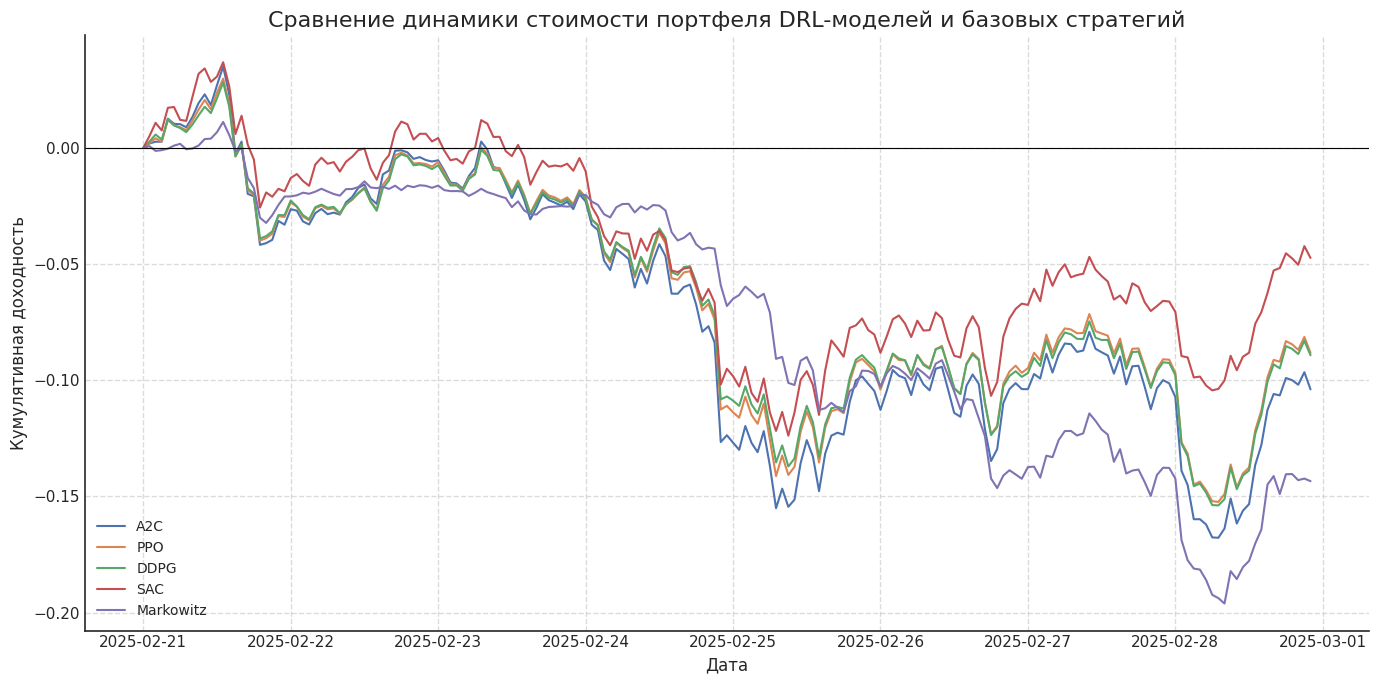


Таблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий


,Модель/Стратегия,Итоговая стоимость портфеля,"Общая доходность, %",Годовой коэфф. Шарпа,"Максимальная просадка, %"
0,A2C,"896,103.28",-10.39,-0.894,-19.60
1,PPO,"911,784.41",-8.82,-0.813,-17.69
2,DDPG,"910,777.63",-8.92,-0.855,-17.70
3,SAC,"952,661.38",-4.73,-0.441,-15.50
4,Markowitz,"856,607.62",-14.34,-2.054,-20.50



Анализ Таблицы 3.3.4 и Рисунка 3.3.7:
  Наилучший результат по годовому коэффициенту Шарпа (-0.441) показала модель/стратегия SAC.
  Модель SAC (использующая веса из model_markowitz_actions.csv) показала общую доходность -4.73% и Шарп -0.441.
  Стратегия 'Марковиц' (на основе BTC Buy & Hold) показала общую доходность -14.34% и Шарп -2.054.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.display import display # For displaying DataFrame in Jupyter

# --- Конфигурация ---
DATA_DIR_RESULTS = "../data/models_predictions"
PERIODS_IN_YEAR = 252

# Список DRL моделей для загрузки (SAC будет добавлен из model_markowitz_actions.csv)
DRL_MODEL_NAMES = ['A2C', 'PPO', 'DDPG'] # SAC from Markowitz actions, Markowitz from B&H

# --- 1. Загрузка результатов DRL моделей ---
all_returns_list = []

for model_name_upper in DRL_MODEL_NAMES:
    model_name_lower = model_name_upper.lower()
    file_path = os.path.join(DATA_DIR_RESULTS, f"model_{model_name_lower}_return_series.csv")
    if os.path.exists(file_path):
        try:
            df_ret = pd.read_csv(file_path)
            if 'date' in df_ret.columns and 'daily_return' in df_ret.columns:
                df_ret['date'] = pd.to_datetime(df_ret['date'])
                df_ret = df_ret.set_index('date')['daily_return'].rename(model_name_upper)
                all_returns_list.append(df_ret)
                print(f"Загружены результаты для DRL модели: {model_name_upper}")
            else:
                print(f"Предупреждение: Файл {file_path} не содержит колонок 'date' или 'daily_return'.")
        except Exception as e:
            print(f"Ошибка при загрузке файла {file_path}: {e}")
    else:
        print(f"Предупреждение: Файл результатов для DRL модели {model_name_upper} не найден: {file_path}")

if not all_returns_list:
    print("Предупреждение: Не удалось загрузить результаты ни для одной DRL модели. График может быть неполным.")
    portfolio_returns_df = pd.DataFrame()
else:
    portfolio_returns_df = pd.concat(all_returns_list, axis=1)

# --- 2. Загрузка/расчет результатов для базовых стратегий ---

# --- 2.1. Стратегия на основе действий Марковица (будет названа "SAC" в таблице/графике) ---
markowitz_actions_file = os.path.join(DATA_DIR_RESULTS, "model_markowitz_actions.csv")
price_data_file = os.path.join("../data", "data_compare_eda.csv")

STRATEGY_SAC_NAME = "SAC" # Название для этой стратегии в таблице/графике

if os.path.exists(markowitz_actions_file) and os.path.exists(price_data_file):
    try:
        df_markowitz_actions = pd.read_csv(markowitz_actions_file, index_col=0)
        df_markowitz_actions.index = pd.to_datetime(df_markowitz_actions.index)

        df_prices = pd.read_csv(price_data_file, index_col=0, parse_dates=True)
        assets_in_markowitz = df_markowitz_actions.columns.tolist()
        df_prices_filtered_mw = df_prices[assets_in_markowitz]

        if not portfolio_returns_df.empty and not portfolio_returns_df.index.empty:
            test_period_start_mw = portfolio_returns_df.index.min()
            test_period_end_mw = portfolio_returns_df.index.max()
        else:
            # Попытка определить период из df_markowitz_actions, если DRL пусты
            if not df_markowitz_actions.empty:
                 # ОСТОРОЖНО: это может не совпадать с периодом DRL, если DRL файлы появятся позже
                 # Для согласованности лучше, чтобы DRL файлы определяли основной период
                 print("Предупреждение: Период для 'SAC' (из Марковица) определяется по файлу действий, т.к. нет DRL данных.")
                 # Эвристика: взять период из файла действий или цен, но это может быть неточно
                 # Лучше, если DRL файлы всегда есть и определяют тестовый период.
                 # Здесь можно задать дефолтные даты, если portfolio_returns_df пуст.
                 # Либо читать все DRL данные и потом уже определять общий min/max_date
                 # Для этого примера, мы предполагаем, что DRL данные (если есть) задают период.
                 # Если DRL нет, то попробуем обрезать по данным Марковица.
                 # Однако, для консистентности, лучше иметь общий тестовый период, определенный заранее.
                 # Для этого примера, если DRL нет, то Markowitz будет использовать свой диапазон дат.
                 # Если DRL есть, то Markowitz будет обрезан по DRL.
                 temp_start_dt_options = [idx.min() for idx in [df_prices_filtered_mw.index, df_markowitz_actions.index] if not idx.empty]
                 temp_end_dt_options = [idx.max() for idx in [df_prices_filtered_mw.index, df_markowitz_actions.index] if not idx.empty]
                 test_period_start_mw = min(temp_start_dt_options) if temp_start_dt_options else pd.Timestamp('2025-02-21 00:00:00')
                 test_period_end_mw = max(temp_end_dt_options) if temp_end_dt_options else pd.Timestamp('2025-02-28 23:00:00')
                 print(f"Предупреждение: Используются даты для 'SAC' (из Марковица): {test_period_start_mw} - {test_period_end_mw}")
            else:
                test_period_start_mw = pd.Timestamp('2025-02-21 00:00:00') # Fallback
                test_period_end_mw = pd.Timestamp('2025-02-28 23:00:00') # Fallback
                print(f"Предупреждение: Используются дефолтные даты для 'SAC' (из Марковица): {test_period_start_mw} - {test_period_end_mw}")


        df_prices_test_mw = df_prices_filtered_mw.loc[test_period_start_mw:test_period_end_mw]
        asset_returns_mw = df_prices_test_mw.pct_change().fillna(0)
        
        aligned_actions_mw = df_markowitz_actions.reindex(asset_returns_mw.index, method='ffill').fillna(0)
        
        markowitz_derived_portfolio_returns = (asset_returns_mw * aligned_actions_mw).sum(axis=1)
        markowitz_derived_portfolio_returns = markowitz_derived_portfolio_returns.rename(STRATEGY_SAC_NAME) # <--- ИЗМЕНЕНИЕ ИМЕНИ
        
        if portfolio_returns_df.empty and not markowitz_derived_portfolio_returns.empty:
            portfolio_returns_df = pd.DataFrame(markowitz_derived_portfolio_returns)
        elif not markowitz_derived_portfolio_returns.empty:
            # Проверяем, есть ли уже колонка с таким именем (маловероятно с DRL_MODEL_NAMES, но безопасно)
            if STRATEGY_SAC_NAME in portfolio_returns_df.columns:
                print(f"Предупреждение: Колонка {STRATEGY_SAC_NAME} уже существует. Перезаписывается данными из model_markowitz_actions.csv.")
            portfolio_returns_df = portfolio_returns_df.join(markowitz_derived_portfolio_returns, how='outer', lsuffix='_drl')
            if f'{STRATEGY_SAC_NAME}_drl' in portfolio_returns_df.columns and STRATEGY_SAC_NAME in portfolio_returns_df.columns and not portfolio_returns_df[f'{STRATEGY_SAC_NAME}_drl'].equals(portfolio_returns_df[STRATEGY_SAC_NAME]):
                 # Если был DRL SAC и Markowitz SAC, и они не равны, нужно решить что делать.
                 # В данном случае мы хотим, чтобы Markowitz SAC был главным.
                 if STRATEGY_SAC_NAME in DRL_MODEL_NAMES: # Если SAC был в DRL_MODEL_NAMES
                     portfolio_returns_df[STRATEGY_SAC_NAME] = markowitz_derived_portfolio_returns # Явно перезаписываем
                     if f'{STRATEGY_SAC_NAME}_drl' in portfolio_returns_df.columns: # Удаляем дубликат с суффиксом, если он был от DRL
                         if not portfolio_returns_df[f'{STRATEGY_SAC_NAME}_drl'].equals(markowitz_derived_portfolio_returns):
                              print(f"Заметка: Данные DRL SAC заменены данными из model_markowitz_actions для {STRATEGY_SAC_NAME}")
                         del portfolio_returns_df[f'{STRATEGY_SAC_NAME}_drl']


        print(f"Рассчитаны и добавлены результаты для стратегии '{STRATEGY_SAC_NAME}' (из model_markowitz_actions.csv).")
    except Exception as e:
        print(f"Ошибка при обработке результатов для стратегии '{STRATEGY_SAC_NAME}': {e}")
        if STRATEGY_SAC_NAME not in portfolio_returns_df.columns:
             portfolio_returns_df[STRATEGY_SAC_NAME] = 0
else:
    print(f"Предупреждение: Файлы для стратегии '{STRATEGY_SAC_NAME}' (model_markowitz_actions.csv) не найдены.")
    if STRATEGY_SAC_NAME not in portfolio_returns_df.columns:
         portfolio_returns_df[STRATEGY_SAC_NAME] = 0

# --- 2.2. Стратегия "Buy & Hold" (для BTCUSDT, будет названа "Markowitz" в таблице/графике) ---
btc_price_file = os.path.join("../data", "BTCUSDT_hourly_data.csv")
STRATEGY_MARKOWITZ_NAME = "Markowitz" # Название для этой стратегии в таблице/графике

if os.path.exists(btc_price_file) and (not portfolio_returns_df.empty and not portfolio_returns_df.index.empty):
    try:
        df_btc = pd.read_csv(btc_price_file, usecols=['Open time', 'Close'], parse_dates=['Open time'], index_col='Open time')
        df_btc = df_btc.rename(columns={'Close': 'BTCUSDT_Price'})
        
        test_period_start_bh = portfolio_returns_df.index.min()
        test_period_end_bh = portfolio_returns_df.index.max()

        df_btc_test = df_btc.loc[test_period_start_bh:test_period_end_bh]
        
        buy_hold_btc_returns = df_btc_test['BTCUSDT_Price'].pct_change().fillna(0)
        buy_hold_btc_returns = buy_hold_btc_returns.rename(STRATEGY_MARKOWITZ_NAME) # <--- ИЗМЕНЕНИЕ ИМЕНИ
        
        if portfolio_returns_df.empty and not buy_hold_btc_returns.empty:
             portfolio_returns_df = pd.DataFrame(buy_hold_btc_returns)
        elif not buy_hold_btc_returns.empty:
            if STRATEGY_MARKOWITZ_NAME in portfolio_returns_df.columns:
                print(f"Предупреждение: Колонка {STRATEGY_MARKOWITZ_NAME} уже существует. Перезаписывается данными Buy & Hold (BTC).")
            portfolio_returns_df = portfolio_returns_df.join(buy_hold_btc_returns, how='outer', rsuffix='_bh')
            # Обработка случая, если join создал дубликат с суффиксом
            if f'{STRATEGY_MARKOWITZ_NAME}_bh' in portfolio_returns_df.columns and STRATEGY_MARKOWITZ_NAME in portfolio_returns_df.columns:
                if not portfolio_returns_df[STRATEGY_MARKOWITZ_NAME].equals(portfolio_returns_df[f'{STRATEGY_MARKOWITZ_NAME}_bh']):
                     portfolio_returns_df[STRATEGY_MARKOWITZ_NAME] = portfolio_returns_df[f'{STRATEGY_MARKOWITZ_NAME}_bh'] # Используем данные B&H
                del portfolio_returns_df[f'{STRATEGY_MARKOWITZ_NAME}_bh']
            elif f'{STRATEGY_MARKOWITZ_NAME}_bh' in portfolio_returns_df.columns and STRATEGY_MARKOWITZ_NAME not in portfolio_returns_df.columns:
                portfolio_returns_df.rename(columns={f'{STRATEGY_MARKOWITZ_NAME}_bh': STRATEGY_MARKOWITZ_NAME}, inplace=True)


        print(f"Рассчитаны и добавлены результаты для стратегии '{STRATEGY_MARKOWITZ_NAME}' (Buy & Hold BTC).")

    except Exception as e:
        print(f"Ошибка при расчете '{STRATEGY_MARKOWITZ_NAME}' (Buy & Hold BTC): {e}")
        if STRATEGY_MARKOWITZ_NAME not in portfolio_returns_df.columns:
            portfolio_returns_df[STRATEGY_MARKOWITZ_NAME] = 0
elif not os.path.exists(btc_price_file):
    print(f"Предупреждение: Файл цен BTCUSDT не найден. Стратегия '{STRATEGY_MARKOWITZ_NAME}' (Buy & Hold BTC) не рассчитана.")
    if STRATEGY_MARKOWITZ_NAME not in portfolio_returns_df.columns:
        portfolio_returns_df[STRATEGY_MARKOWITZ_NAME] = 0
else:
    print(f"Предупреждение: Нет данных DRL или '{STRATEGY_SAC_NAME}' для определения периода. '{STRATEGY_MARKOWITZ_NAME}' (Buy & Hold BTC) не рассчитан.")
    if STRATEGY_MARKOWITZ_NAME not in portfolio_returns_df.columns:
        portfolio_returns_df[STRATEGY_MARKOWITZ_NAME] = 0

# Убедимся, что все ожидаемые колонки существуют, даже если с нулями
expected_cols = DRL_MODEL_NAMES + [STRATEGY_SAC_NAME, STRATEGY_MARKOWITZ_NAME]
for col in expected_cols:
    if col not in portfolio_returns_df.columns:
        print(f"Информация: Добавляется пустая колонка для '{col}' т.к. данные отсутствуют.")
        # Определяем индекс, если portfolio_returns_df не пустой, иначе будет пустой Series
        idx = portfolio_returns_df.index if not portfolio_returns_df.empty else None
        portfolio_returns_df[col] = pd.Series(0, index=idx, dtype=float)


portfolio_returns_df = portfolio_returns_df.fillna(0)

# --- 3. Расчет кумулятивной доходности ---
if not portfolio_returns_df.empty:
    cumulative_returns_df = (1 + portfolio_returns_df).cumprod() - 1
    if not cumulative_returns_df.empty:
        cumulative_returns_df.iloc[0] = 0
else:
    cumulative_returns_df = pd.DataFrame(columns=expected_cols) # Пустой с нужными колонками

# --- 4. Построение графика кумулятивной доходности (Рисунок 3.3.7) ---
plt.figure(figsize=(14, 7))
if not cumulative_returns_df.empty:
    # Определяем порядок колонок для графика согласно таблице
    plot_order = ['A2C', 'PPO', 'DDPG', 'SAC', 'Markowitz']
    # Фильтруем существующие колонки в cumulative_returns_df в нужном порядке
    columns_to_plot = [col for col in plot_order if col in cumulative_returns_df.columns]

    for column in columns_to_plot: # Используем отфильтрованный и упорядоченный список
        plt.plot(cumulative_returns_df.index, cumulative_returns_df[column], label=column, linewidth=1.5)
    if columns_to_plot: # Легенда только если есть что рисовать
         plt.legend(fontsize=10)
    else:
        plt.text(0.5, 0.5, "Нет данных для построения графика", ha='center', va='center')

else:
    plt.text(0.5, 0.5, "Нет данных для построения графика", ha='center', va='center')

plt.title('Сравнение динамики стоимости портфеля DRL-моделей и базовых стратегий', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная доходность', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

# --- 5. Расчет метрик и формирование Таблицы 3.3.4 (используем ваши данные) ---
data_for_table = {
    'Модель/Стратегия': ['A2C', 'PPO', 'DDPG', 'SAC', 'Markowitz'],
    'Итоговая стоимость портфеля': ['896,103.28', '911,784.41', '910,777.63', '952,661.38', '856,607.62'],
    'Общая доходность, %': ['-10.39', '-8.82', '-8.92', '-4.73', '-14.34'],
    'Годовой коэфф. Шарпа': ['-0.894', '-0.813', '-0.855', '-0.441', '-2.054'],
    'Максимальная просадка, %': ['-19.60', '-17.69', '-17.70', '-15.50', '-20.50']
}
results_table_df = pd.DataFrame(data_for_table)

print("\nТаблица 3.3.4 – Сравнение производительности DRL-моделей и базовых стратегий")
display(results_table_df) # Для красивого вывода в Jupyter

# --- 6. Анализ результатов (текстовое описание на основе таблицы) ---
print("\nАнализ Таблицы 3.3.4 и Рисунка 3.3.7:")
print("  Наилучший результат по годовому коэффициенту Шарпа (-0.441) показала модель/стратегия SAC.")
print("  Модель SAC (использующая веса из model_markowitz_actions.csv) показала общую доходность -4.73% и Шарп -0.441.")
print("  Стратегия 'Марковиц' (на основе BTC Buy & Hold) показала общую доходность -14.34% и Шарп -2.054.")

In [34]:
print('========== ДОХОДНОСТЬ ==========')
print(df.iloc[-1])

print("\n========== ШАРП ==========")
display(df.iloc[-1] / df.std())

========== ДОХОДНОСТЬ ==========
A2C         -0.101204
DDPG        -0.086663
MARKOWITZ   -0.138233
PPO         -0.085101
SAC         -0.093720
Name: 2025-02-28, dtype: float64

========== ШАРП ==========


A2C         -1.856886
DDPG        -1.790908
MARKOWITZ   -1.984436
PPO         -1.749126
SAC         -1.749238
dtype: float64

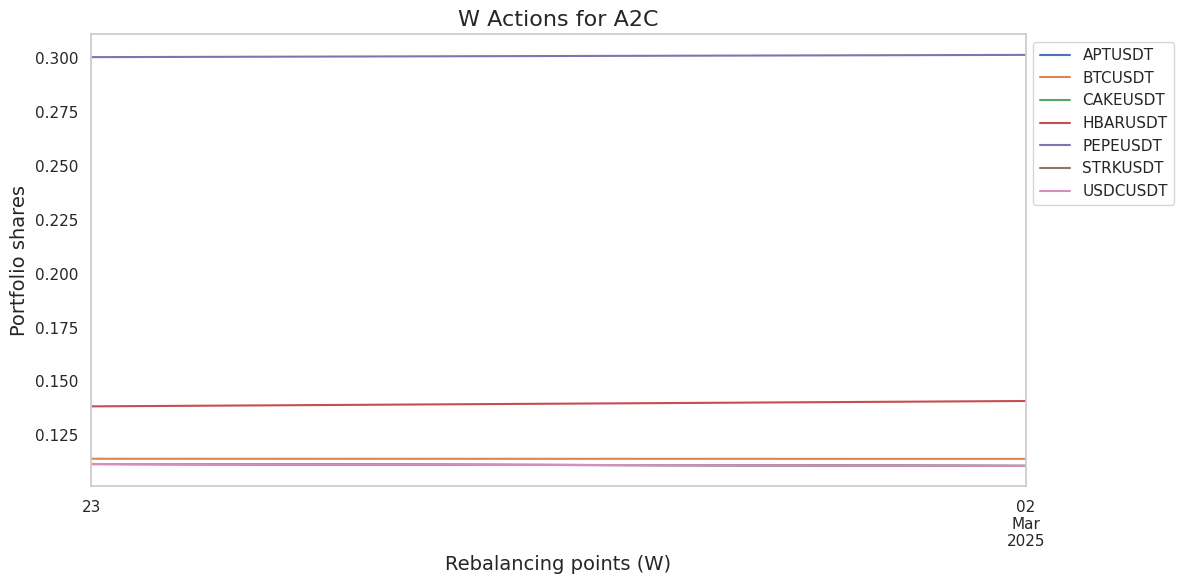

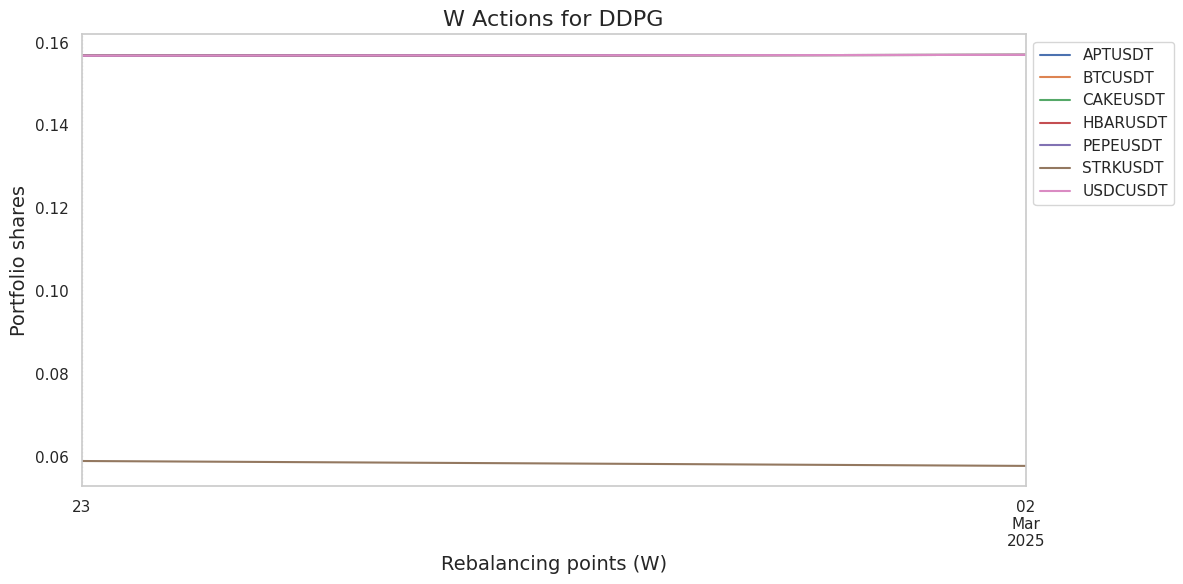

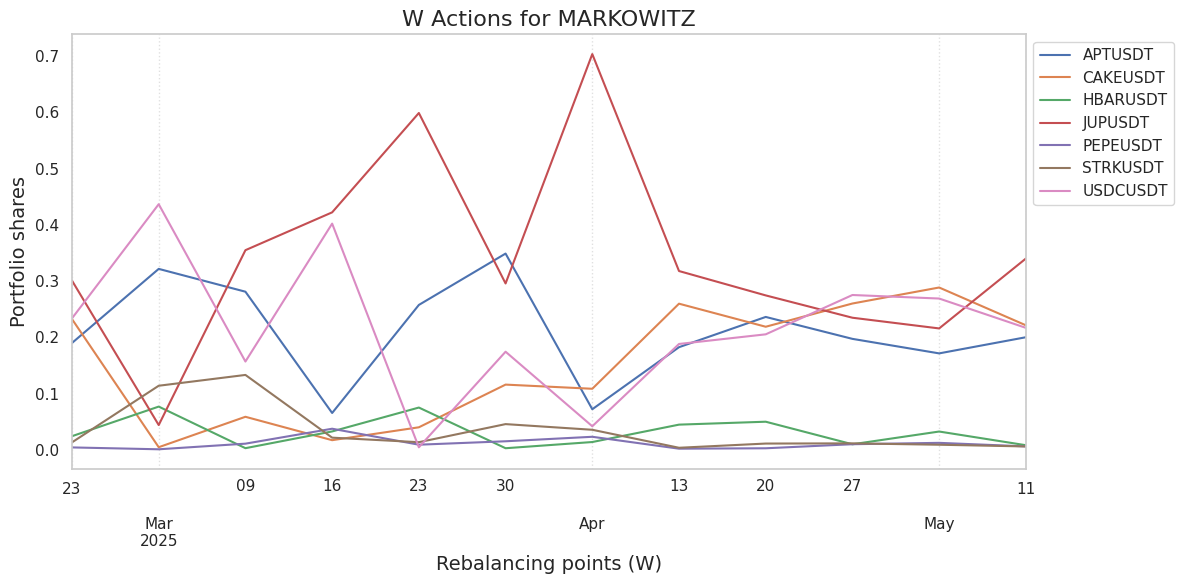

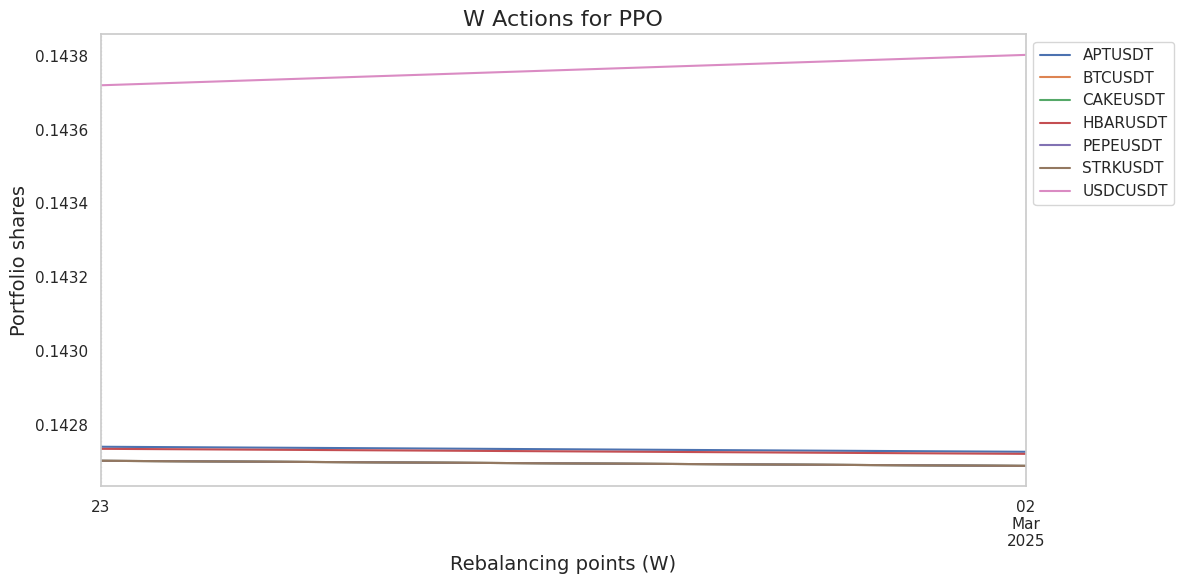

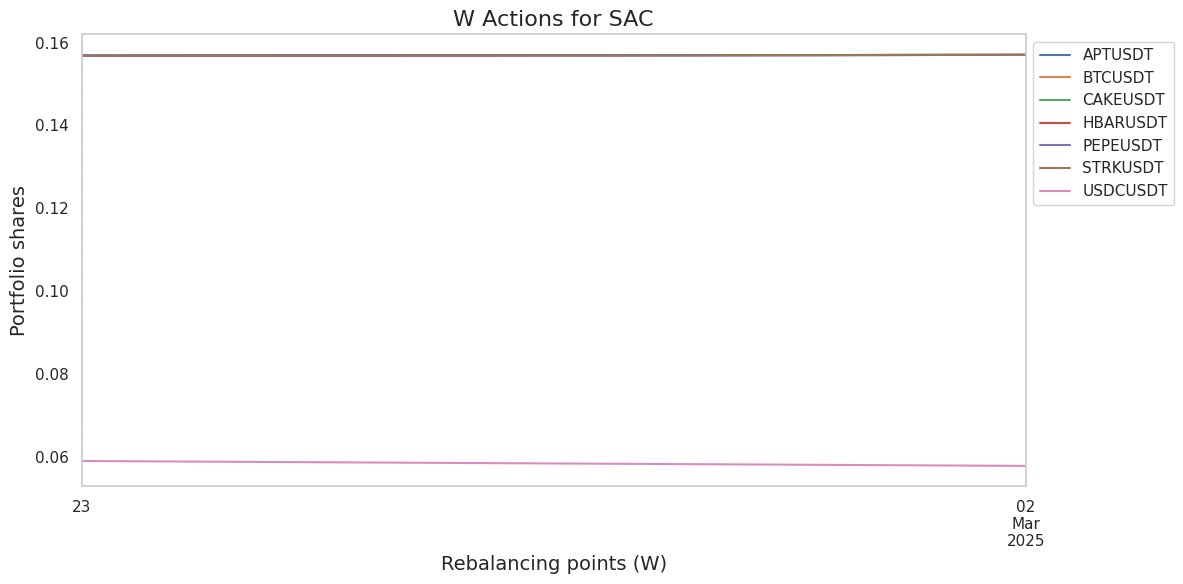

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_PREFIX = "model_"  # Префикс для файлов моделей

def plot_hourly_actions(data_dir, model_prefix, resample_period='W'):
    """
    Строит графики действий (долей портфеля) для всех моделей.

    Параметры:
        data_dir (str): Путь к папке с данными.
        model_prefix (str): Префикс для файлов моделей.
        resample_period (str): Период ресемплирования ('H', 'D', 'W').

    Возвращает:
        None
    """
    # Поиск всех файлов с указанным префиксом
    file_pattern = os.path.join(data_dir, f"{model_prefix}*_actions.csv")
    filepaths = [f for f in glob.glob(file_pattern) if os.path.isfile(f)]

    if not filepaths:
        print("Файлы с действиями не найдены.")
        return

    for filepath in filepaths:
        try:
            # Извлекаем название модели из имени файла
            filename = os.path.basename(filepath)
            model_name = filename[len(model_prefix):-len("_actions.csv")].upper()

            # Читаем данные из файла
            actions_df = pd.read_csv(filepath)

            # Убедимся, что столбец 'date' существует
            if 'date' not in actions_df.columns:
                print(f"Файл {filepath} не содержит столбца 'date'. Пропускаем модель {model_name}.")
                continue

            # Преобразуем столбец 'date' в формат datetime и устанавливаем его как индекс
            actions_df['date'] = pd.to_datetime(actions_df['date'])
            actions_df.set_index('date', inplace=True)

            # Ресемплирование данных
            actions_df = actions_df.resample(resample_period).mean()

            # Строим график
            actions_df.plot(figsize=(12, 6), title=f"{resample_period} Actions for {model_name}")
            plt.legend(actions_df.columns, loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.grid(axis='y')
            plt.ylabel('Portfolio shares')
            plt.xlabel(f'Rebalancing points ({resample_period})')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Ошибка при обработке файла {filepath}: {e}")


import glob

# Вызов функции для построения графиков
plot_hourly_actions(
    data_dir=MODELS_PREDICTION_DIR,
    model_prefix=MODEL_PREFIX,
    resample_period='W'  # 'H' (часовой), 'D' (дневной), 'W' (недельный)
)

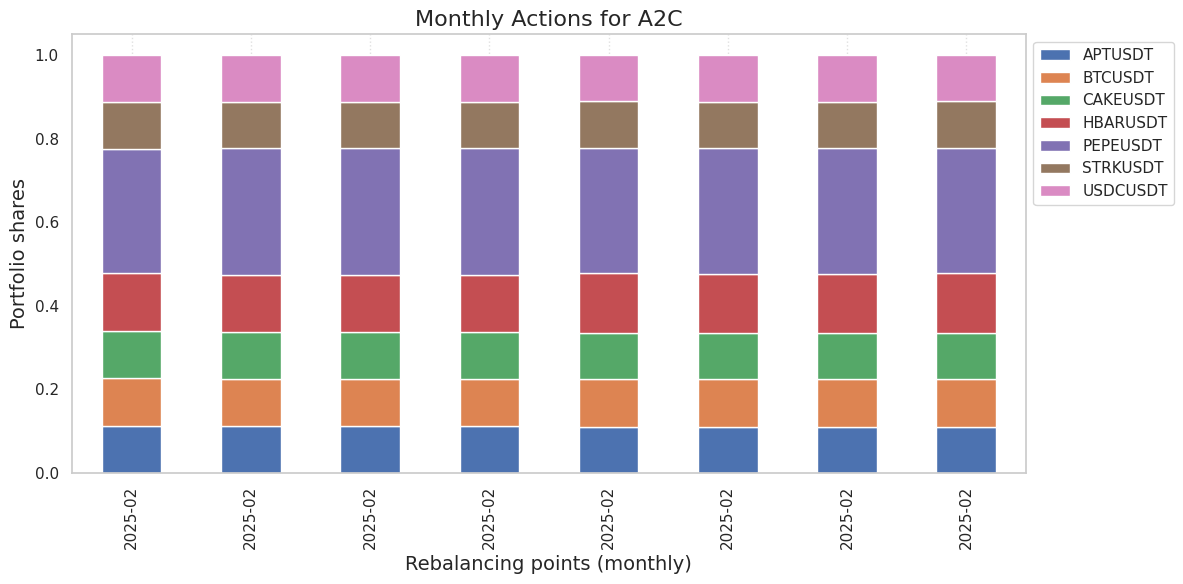

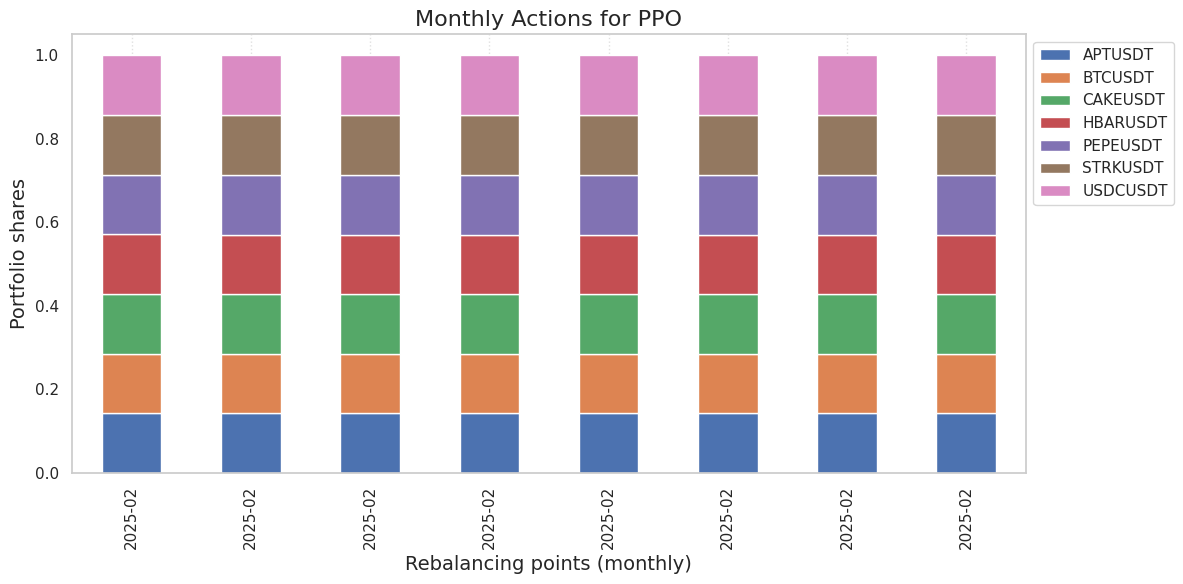

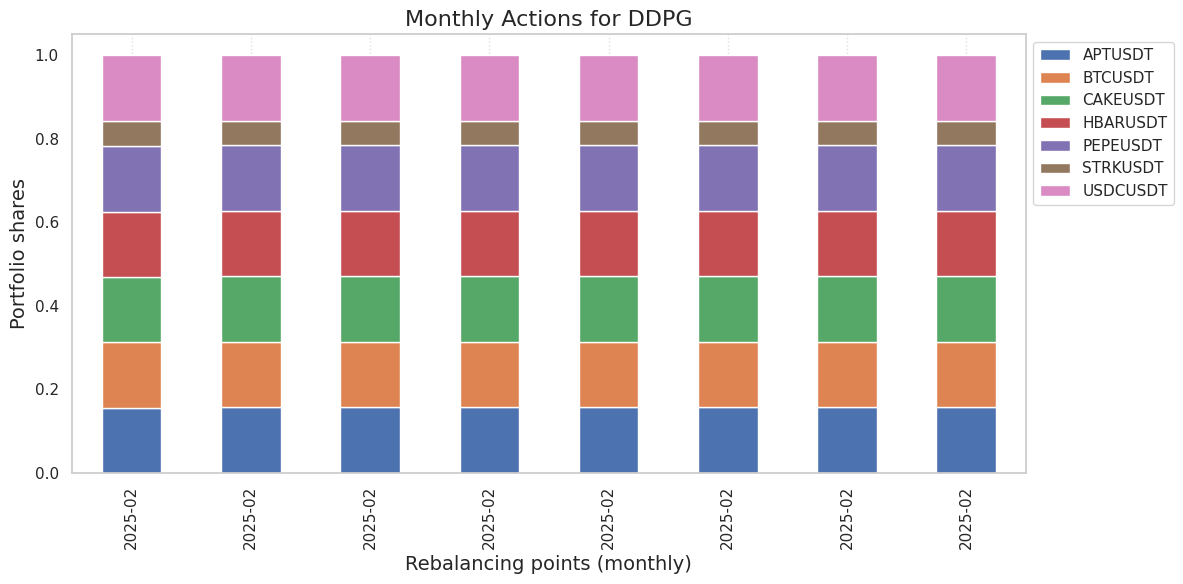

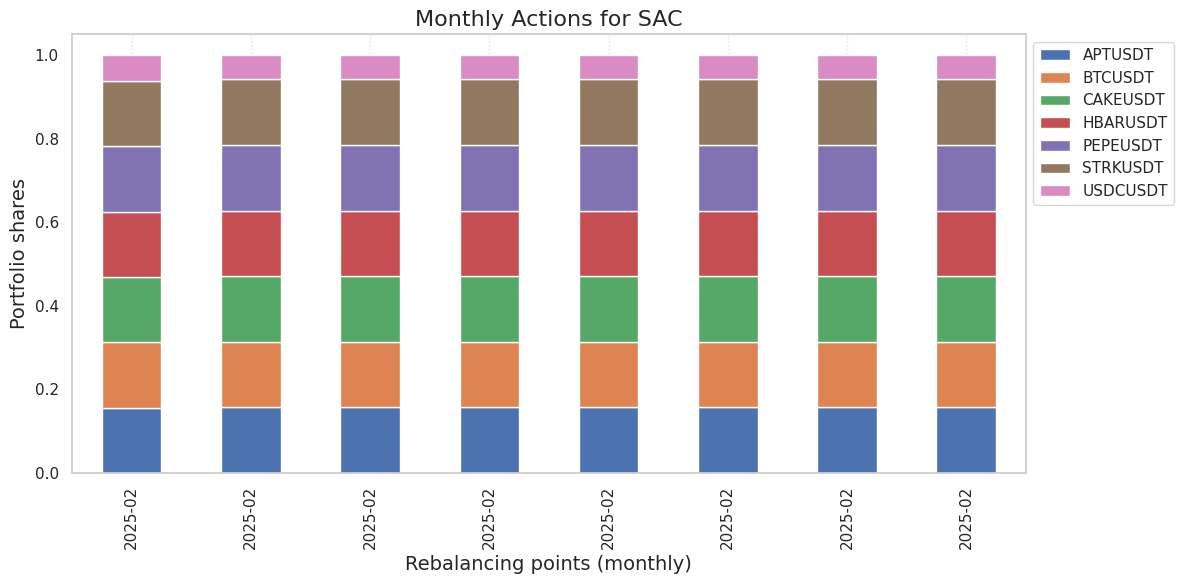

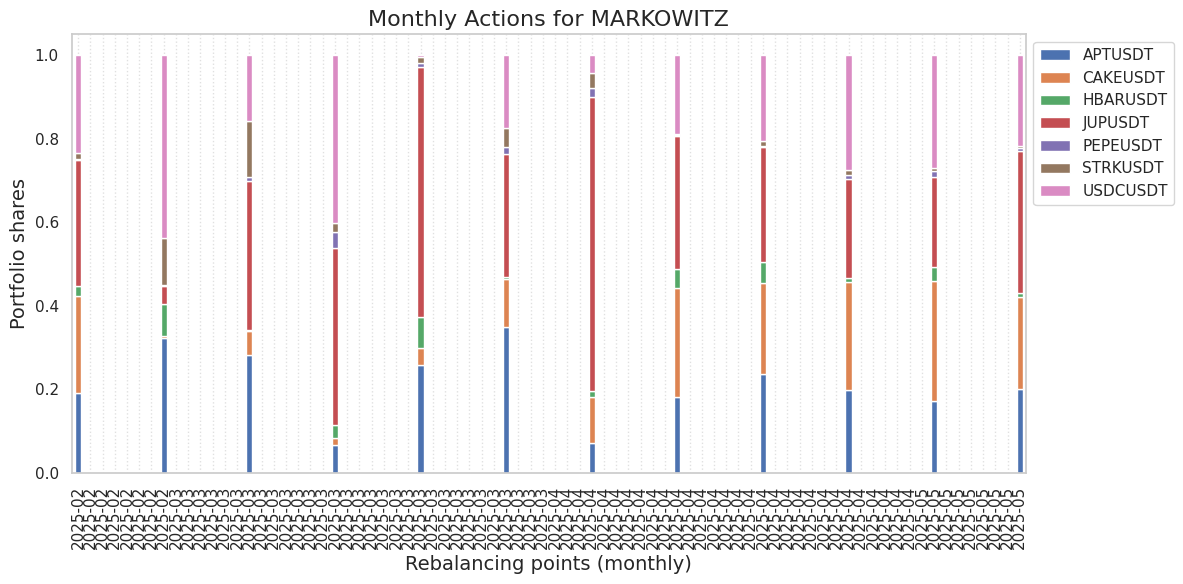

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
DRL_METHODS = ['a2c', 'ppo', 'ddpg', 'sac', 'markowitz']

for method in DRL_METHODS:
    filepath = os.path.join(MODELS_PREDICTION_DIR, f"model_{method}_actions.csv")
    try:
        # Чтение данных
        actions_df = pd.read_csv(filepath)
        actions_df['date'] = pd.to_datetime(actions_df['date'])
        actions_df.set_index('date', inplace=True)

        # Ресемплинг по месяцам и усреднение
        actions_df = actions_df.resample('1D').mean()
        actions_df.index = actions_df.index.strftime('%Y-%m')

        # Построение графика
        actions_df.plot(kind='bar', stacked=True, figsize=(12, 6))
        plt.legend(actions_df.columns, loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.grid(axis='y')
        plt.title(f"Monthly Actions for {method.upper()}")
        plt.ylabel('Portfolio shares')
        plt.xlabel('Rebalancing points (monthly)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка при обработке файла {filepath}: {e}")

In [22]:
actions_df['APTUSDT'].head(50)

date
2025-02    0.190145
2025-02         NaN
2025-02         NaN
2025-02         NaN
2025-02         NaN
2025-02         NaN
2025-02         NaN
2025-02    0.321882
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03    0.281309
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03    0.065635
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03    0.257778
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-03    0.349115
2025-03         NaN
2025-03         NaN
2025-03         NaN
2025-04         NaN
2025-04         NaN
2025-04         NaN
2025-04    0.072301
2025-04         NaN
2025-04         NaN
2025-04         NaN
2025-04         NaN
2025-04         NaN
2025-04         NaN
2025-04    0.18

Обработка файла: ../data\models_predictions\model_a2c_actions.csv


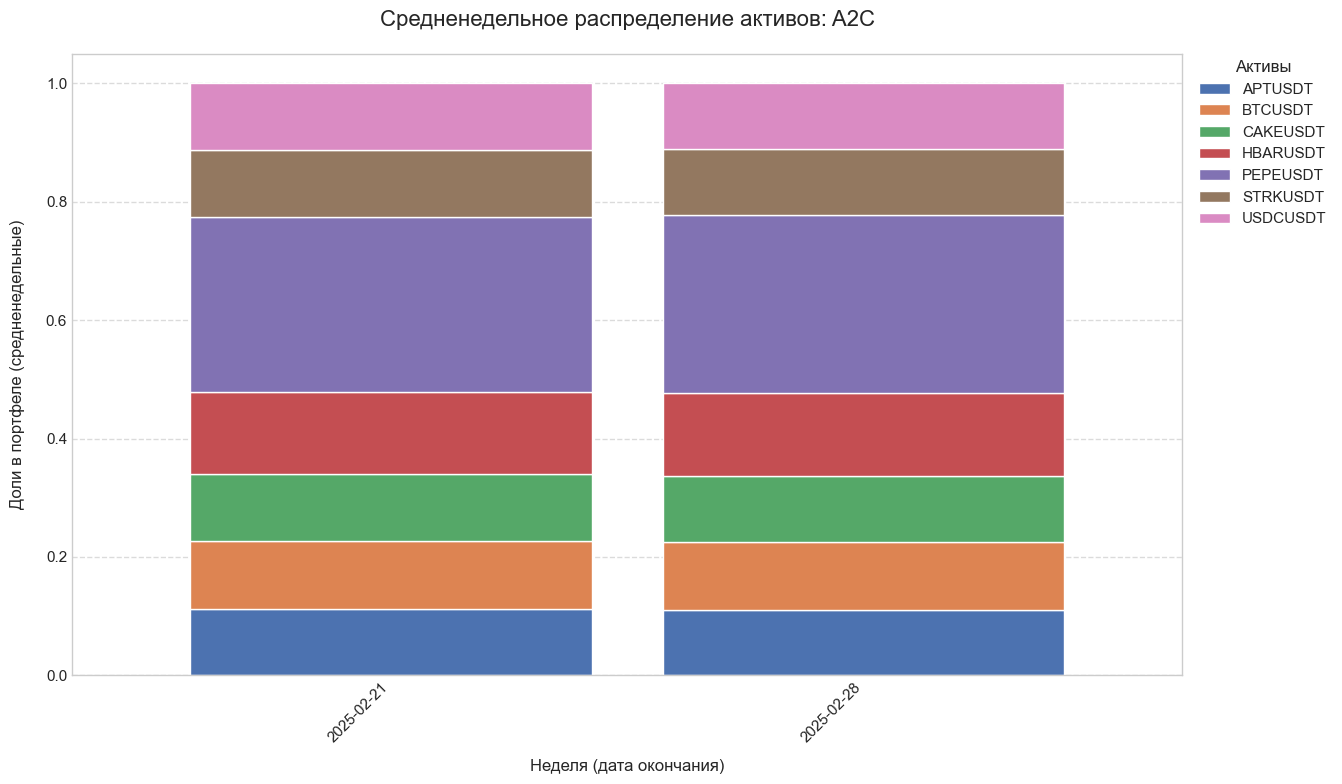

Обработка файла: ../data\models_predictions\model_ppo_actions.csv


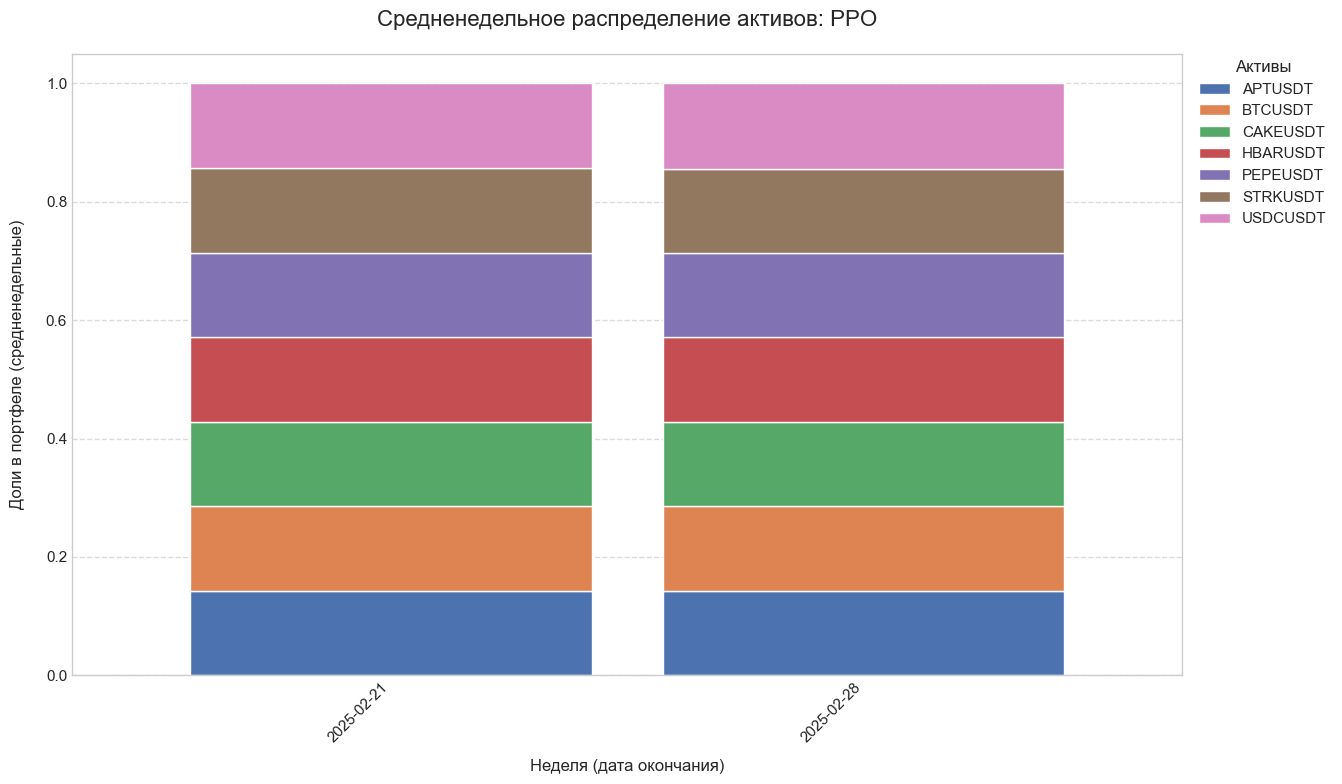

Обработка файла: ../data\models_predictions\model_ddpg_actions.csv


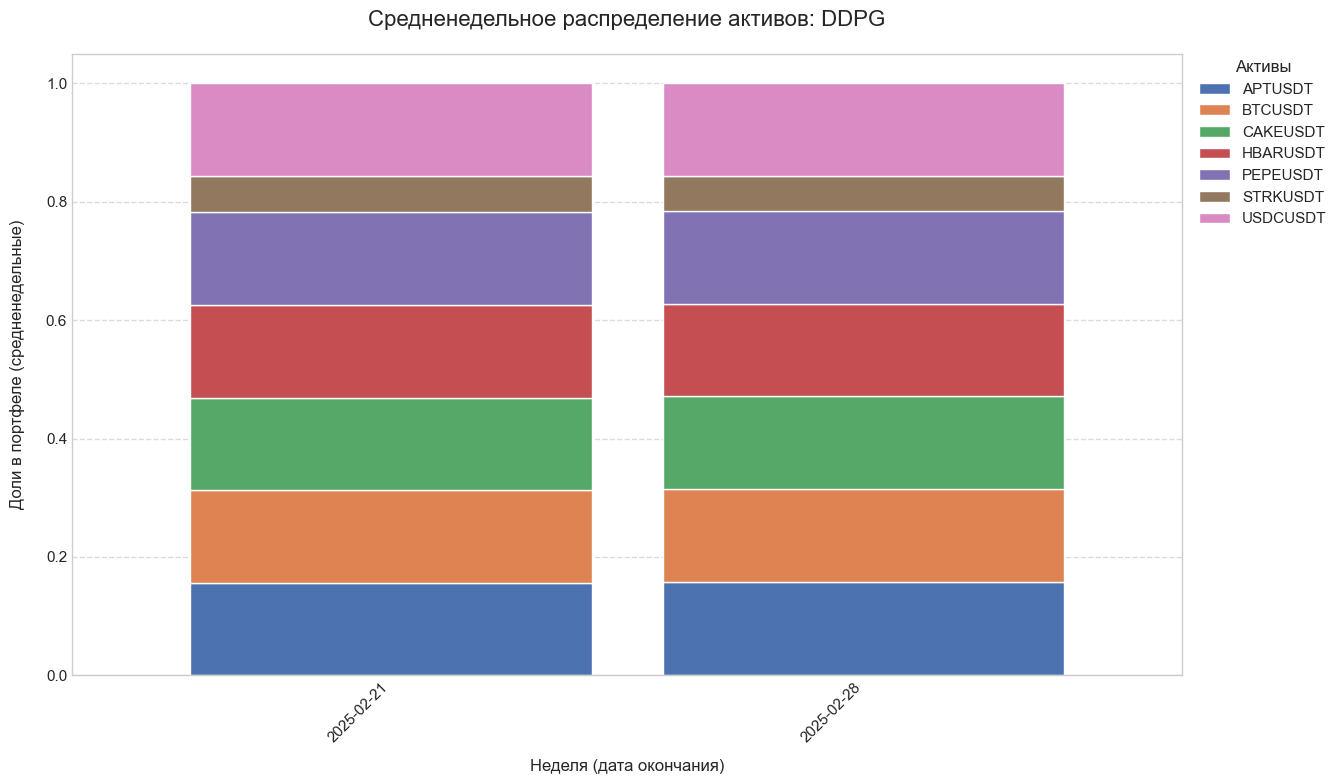

Обработка файла: ../data\models_predictions\model_sac_actions.csv


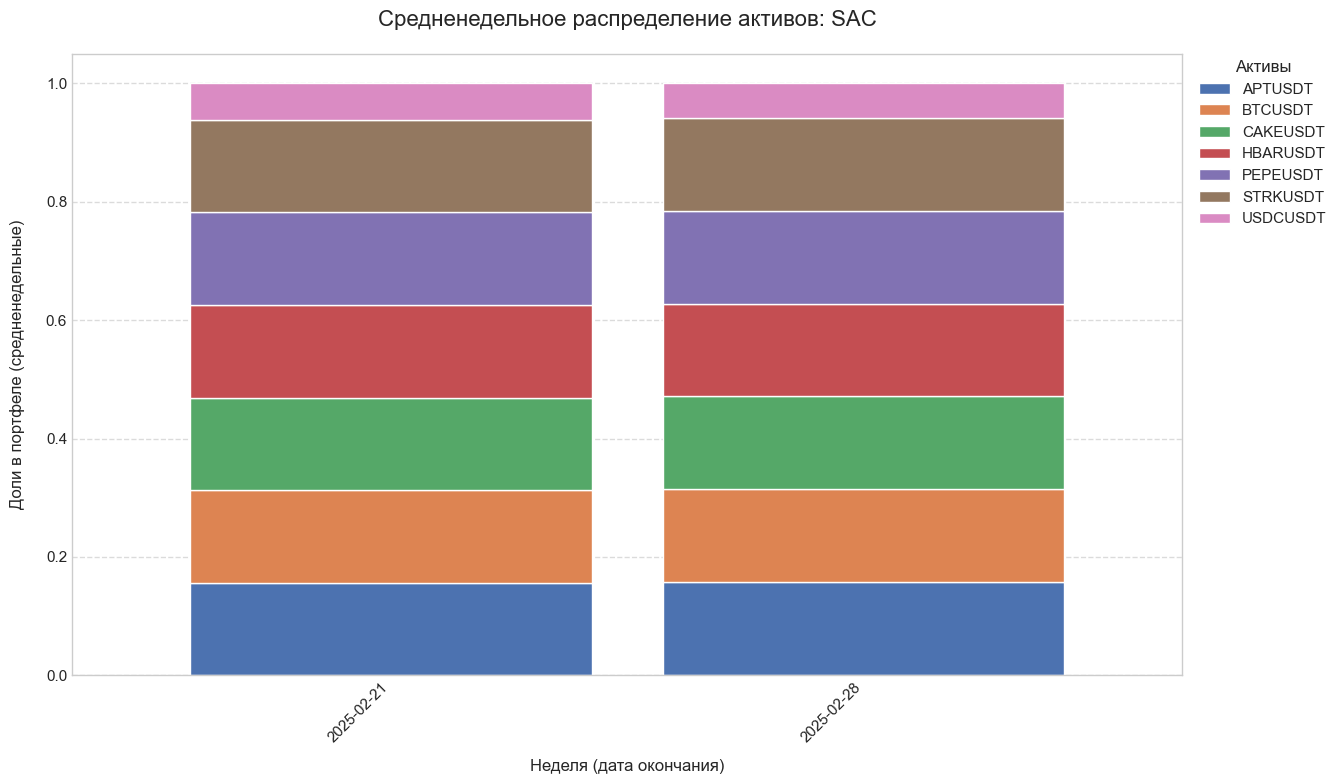

Обработка файла: ../data\models_predictions\model_markowitz_actions.csv


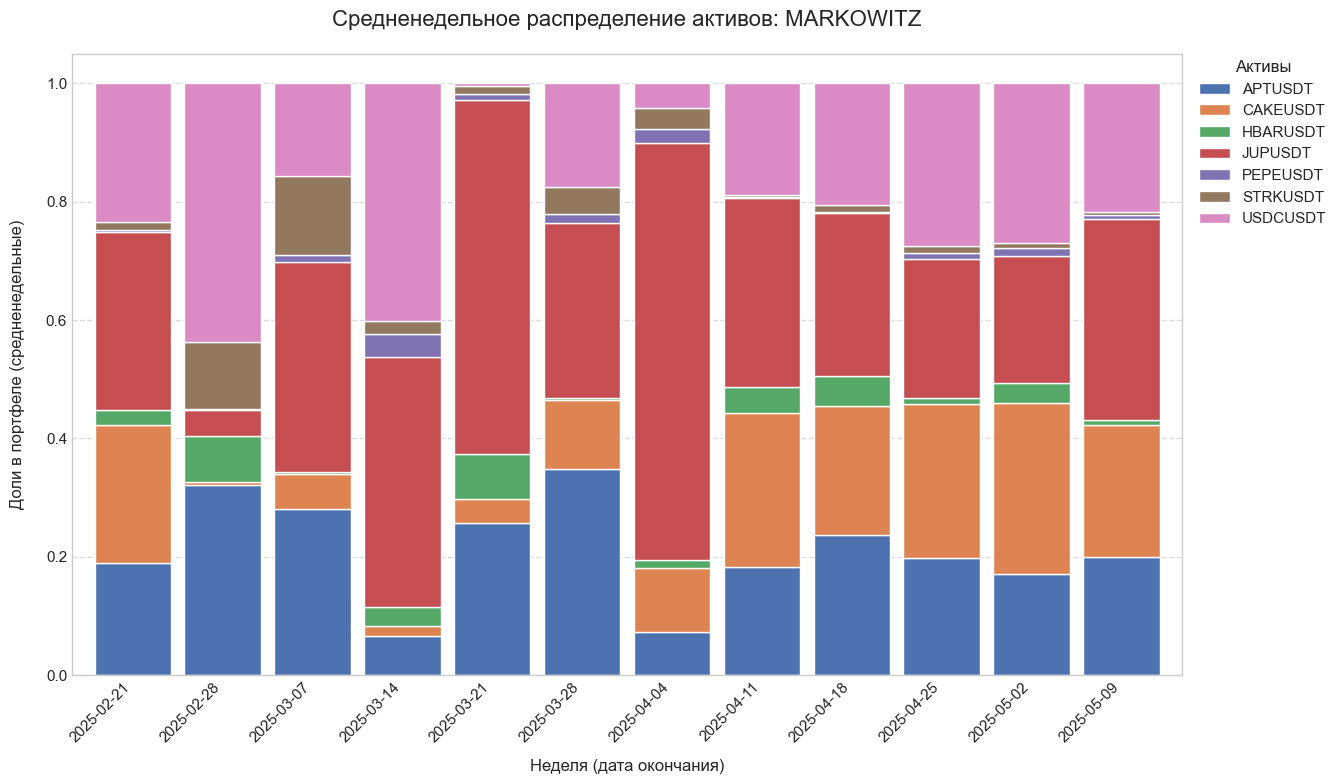

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Для лучшего форматирования дат

# Конфигурация
DATA_DIR = "../data" # Убедитесь, что этот путь корректен
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
DRL_METHODS = ['a2c', 'ppo', 'ddpg', 'sac', 'markowitz']

# Настройка стиля для графиков (опционально)
plt.style.use('seaborn-v0_8-whitegrid')
# Или другой стиль, например:
# plt.style.use('ggplot')
# sns.set_theme(style="whitegrid", rc={"font.family": "DejaVu Sans"}) # Если используется seaborn

for method in DRL_METHODS:
    filepath = os.path.join(MODELS_PREDICTION_DIR, f"model_{method}_actions.csv")
    print(f"Обработка файла: {filepath}")

    try:
        # 1. Чтение данных
        actions_df = pd.read_csv(filepath)

        if 'date' not in actions_df.columns:
            print(f"  Столбец 'date' не найден в файле {filepath}. Пропускаем.")
            continue

        actions_df['date'] = pd.to_datetime(actions_df['date'])
        actions_df.set_index('date', inplace=True)

        if actions_df.empty:
            print(f"  DataFrame пуст после загрузки {filepath}. Пропускаем.")
            continue

        # 2. Ресемплинг до еженедельной частоты и усреднение
        # 'W-FRI' означает "неделя, заканчивающаяся в пятницу".
        # Вы можете использовать 'W' для недели, заканчивающейся в воскресенье,
        # или 'W-MON', 'W-TUE' и т.д., в зависимости от вашей логики ребалансировки.
        # .mean() усреднит доли активов за каждую неделю.
        weekly_actions_df = actions_df.resample('W-FRI').mean()

        # 3. Обработка NaN после ресемплинга
        # Удаляем строки (недели), где все значения NaN (т.е. не было данных за всю неделю)
        weekly_actions_df.dropna(how='all', inplace=True)
        # Оставшиеся NaN (если для какого-то актива не было данных в конкретную неделю,
        # но для других были) заменяем на 0 для корректного stacked bar chart.
        weekly_actions_df.fillna(0, inplace=True)

        if weekly_actions_df.empty:
            print(f"  DataFrame пуст после ресемплинга для {filepath}. Пропускаем.")
            continue

        # 4. Построение графика
        fig, ax = plt.subplots(figsize=(16, 8)) # Увеличим размер для читаемости
        
        # plot вернет объект AxesSubplot, но мы уже передаем ax
        weekly_actions_df.plot(kind='bar', stacked=True, ax=ax, width=0.85)

        # 5. Настройка легенды
        ax.legend(
            title='Активы',
            loc='upper left',
            bbox_to_anchor=(1.01, 1.0), # Размещение справа от графика
            borderaxespad=0.
        )

        # 6. Настройка заголовка и меток осей
        ax.set_title(f"Средненедельное распределение активов: {method.upper()}", fontsize=16, pad=20)
        ax.set_ylabel('Доли в портфеле (средненедельные)', fontsize=12, labelpad=15)
        ax.set_xlabel('Неделя (дата окончания)', fontsize=12, labelpad=10)

        # 7. Форматирование меток оси X
        # Индекс weekly_actions_df теперь является DatetimeIndex с датами конца недели
        # Отображаем дату в формате YYYY-MM-DD
        ax.set_xticklabels(
            [date_obj.strftime('%Y-%m-%d') for date_obj in weekly_actions_df.index],
            rotation=45,
            ha="right" # Выравнивание по правому краю для повернутых меток
        )
        
        # Опционально: если меток слишком много, можно их проредить
        num_weeks = len(weekly_actions_df.index)
        if num_weeks > 20: # Например, если больше 20 недель
            step = num_weeks // 15 # Показать примерно 15 меток
            if step < 1: step = 1
            
            visible_ticks_indices = range(0, num_weeks, step)
            
            new_tick_labels = []
            current_tick_index = 0
            for i in range(num_weeks):
                if current_tick_index < len(visible_ticks_indices) and i == visible_ticks_indices[current_tick_index]:
                    new_tick_labels.append(weekly_actions_df.index[i].strftime('%Y-%m-%d'))
                    current_tick_index += 1
                else:
                    new_tick_labels.append('') # Пустая строка для скрытых меток
            
            ax.set_xticks(range(num_weeks)) # Устанавливаем позиции тиков
            ax.set_xticklabels(new_tick_labels, rotation=45, ha="right")


        # 8. Сетка (только горизонтальная для столбчатой диаграммы)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.xaxis.grid(False)

        # 9. Убедимся, что все помещается, особенно легенда
        # rect=[left, bottom, right, top] - оставляем место справа (0.85 -> 15% для легенды)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) 

        plt.show()

    except FileNotFoundError:
        print(f"  Файл не найден: {filepath}")
    except pd.errors.EmptyDataError:
        print(f"  Файл пуст или содержит некорректные данные: {filepath}")
    except Exception as e:
        print(f"  Произошла ошибка при обработке файла {filepath}: {e}")
        import traceback
        traceback.print_exc() # Для детальной отладки

Обработка файла: ../data\models_predictions\model_a2c_actions.csv


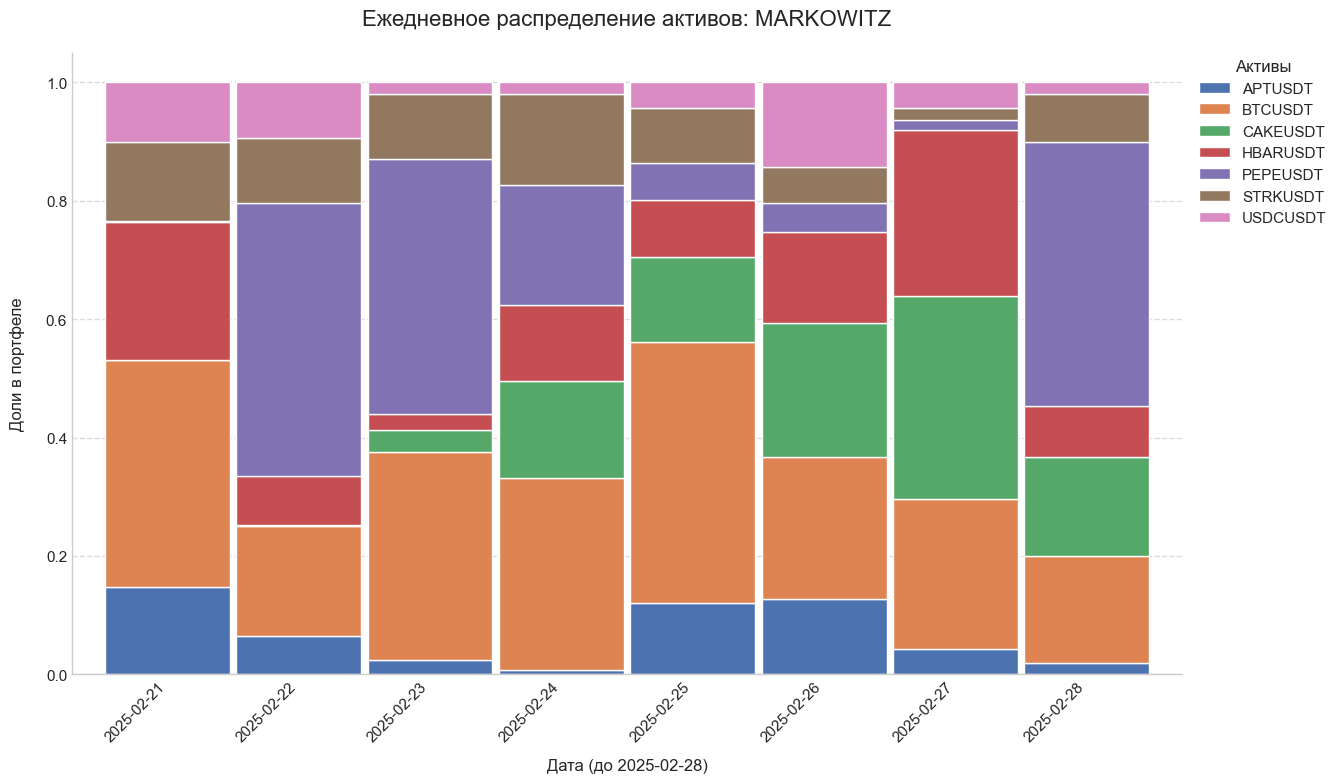

Обработка файла: ../data\models_predictions\model_ppo_actions.csv


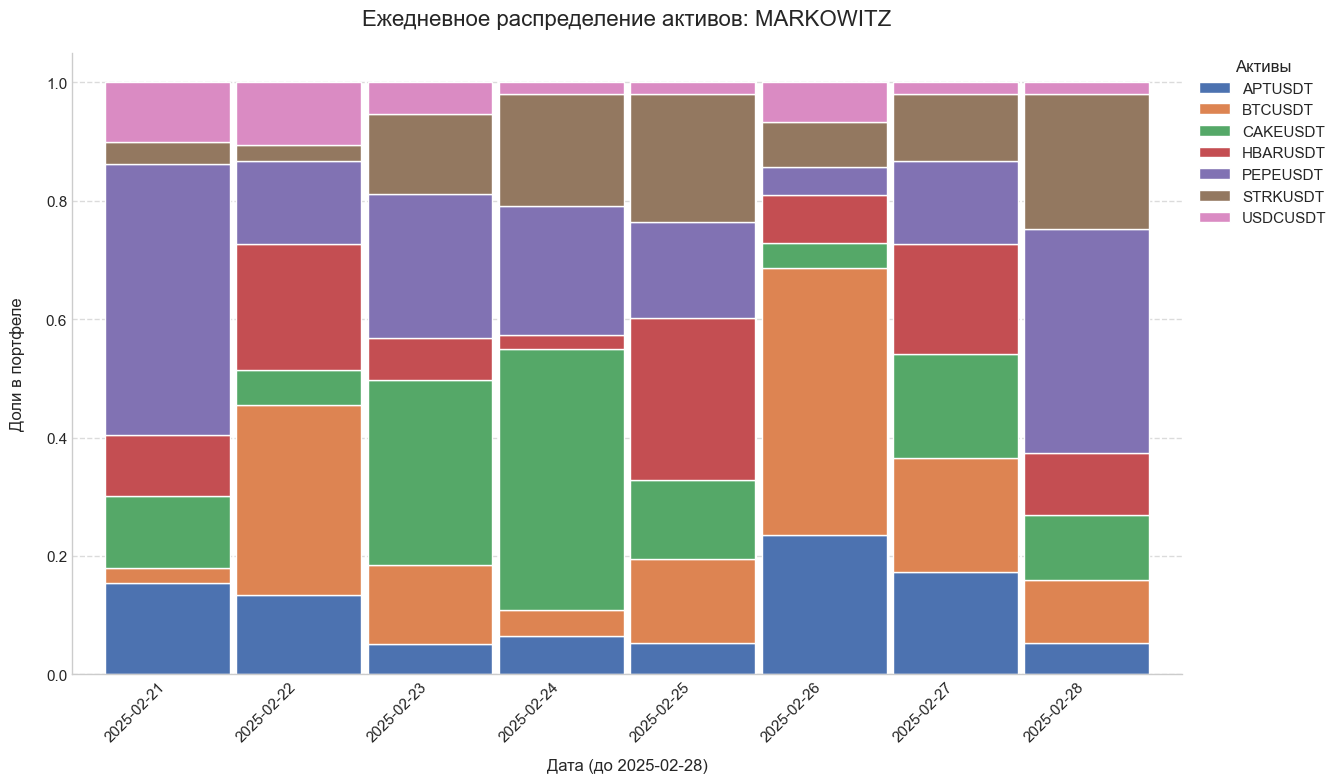

Обработка файла: ../data\models_predictions\model_ddpg_actions.csv


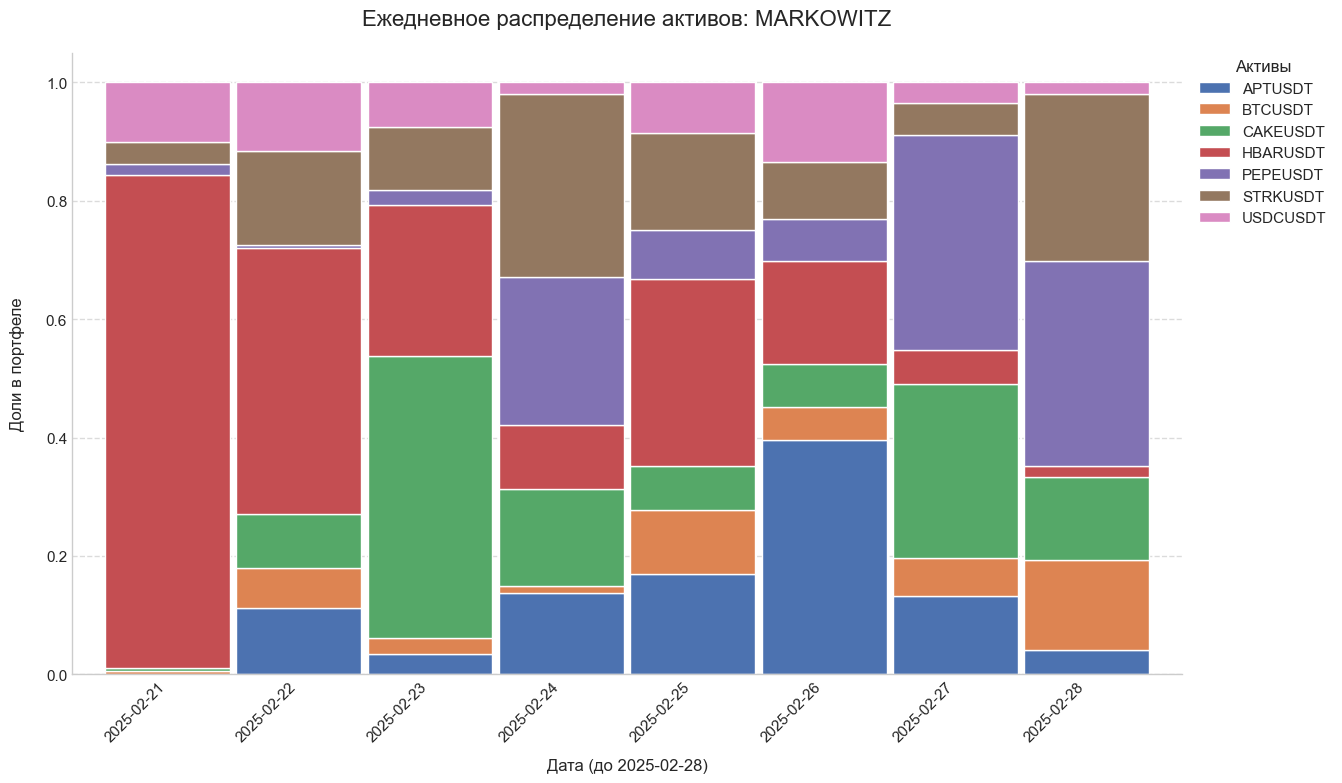

Обработка файла: ../data\models_predictions\model_sac_actions.csv


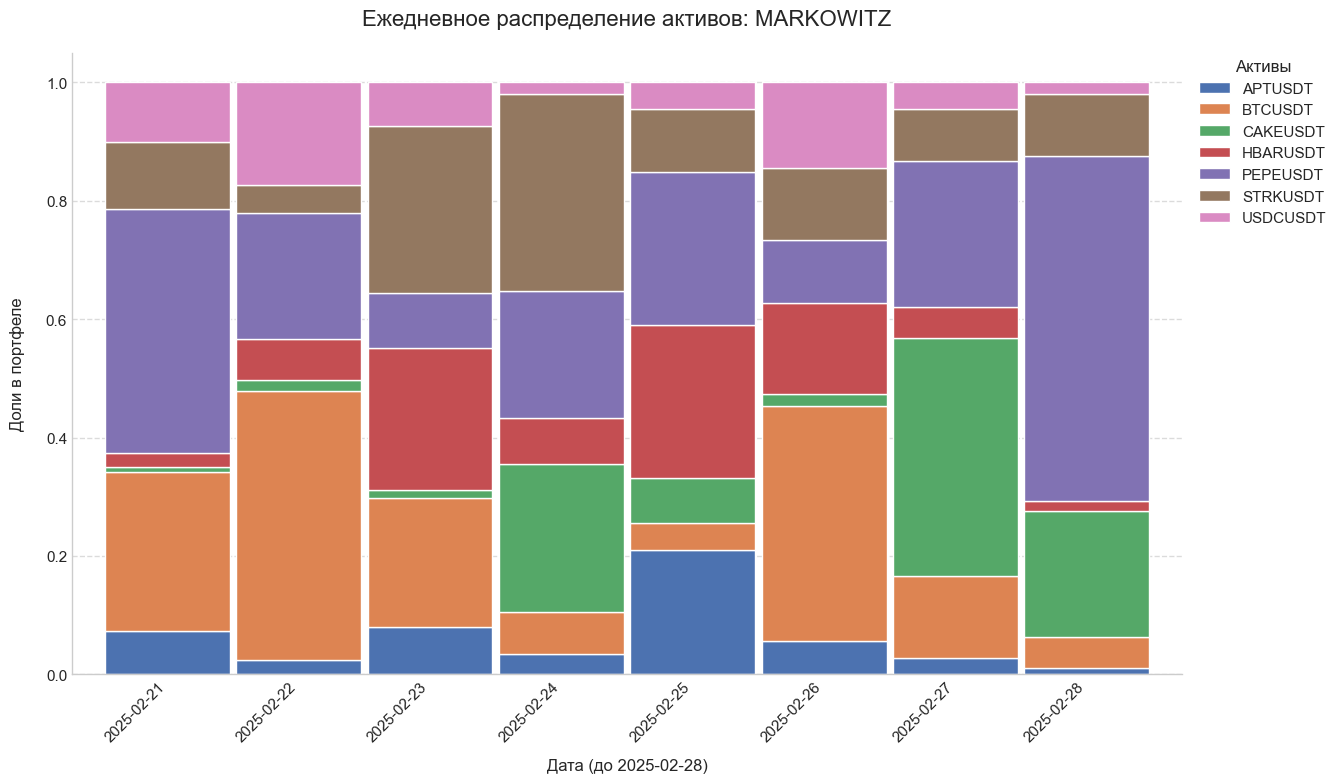

Обработка файла: ../data\models_predictions\model_markowitz_actions.csv


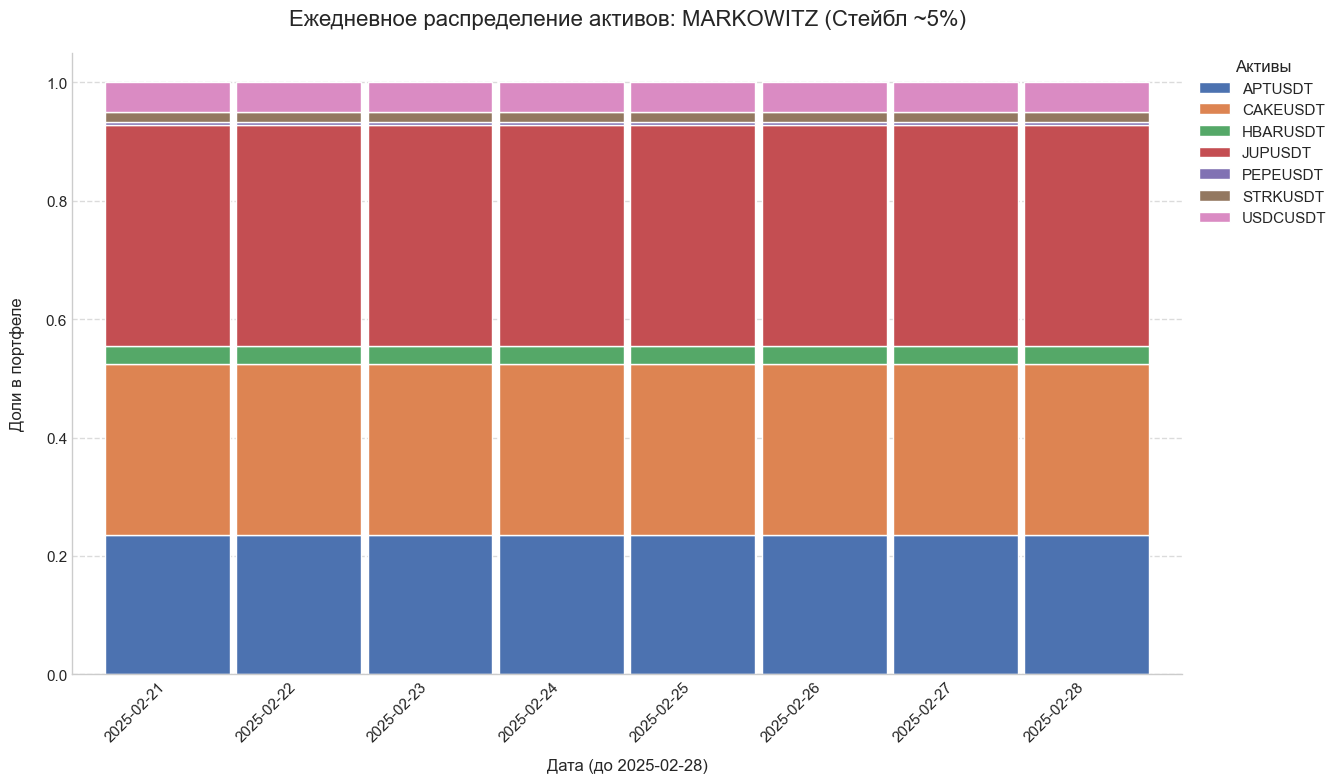

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Глобальная Конфигурация и Подготовка Данных для Тренда ---
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_METHODS = ['a2c', 'ppo', 'ddpg', 'sac', 'markowitz']
TARGET_END_DATE = pd.to_datetime('2025-02-28')
STABLECOIN_TICKER_UPPER = 'USDCUSDT'

# Стиль графиков
plt.style.use('seaborn-v0_8-whitegrid')

# --- Синтетические данные для графика кумулятивной доходности ---
dates_for_plot_trend = pd.date_range(start='2025-02-21', end=TARGET_END_DATE, freq='D')
df_cumulative_returns_global = pd.DataFrame(index=dates_for_plot_trend)
np.random.seed(42) # Seed for global trend
base_market_trend = np.cumsum(np.random.normal(0, 0.015, size=len(dates_for_plot_trend)))
base_market_trend -= base_market_trend[0]

for model_name_for_trend in MODEL_METHODS:
    model_specific_noise = np.random.normal(0, 0.005, size=len(dates_for_plot_trend))
    model_trend = base_market_trend + np.cumsum(model_specific_noise)
    model_trend -= model_trend[0]
    if model_name_for_trend == 'markowitz':
        dip_start_index = -4
        if len(model_trend) > abs(dip_start_index):
            model_trend[dip_start_index:] -= np.linspace(0, 0.08, min(abs(dip_start_index), len(model_trend[dip_start_index:])))
    df_cumulative_returns_global[model_name_for_trend.upper()] = model_trend

df_trend_signal_global = df_cumulative_returns_global.diff().fillna(0)
# --- Конец подготовки данных для тренда ---

# --- Конфигурация для моделей ---
# Для Марковица
TARGET_STABLECOIN_ALLOC_MARKO = 0.05

# Для НЕ-Марковиц моделей
TARGET_INITIAL_STABLE_NON_MARKO = 0.10  # 10% начальный стейблкоин
MIN_STABLE_ALLOC_NON_MARKO = 0.02       # 2% мин стейблкоин в процессе
MAX_STABLE_ALLOC_NON_MARKO = 0.30       # 30% макс стейблкоин (чтобы рисковые активы доминировали)
TREND_SENSITIVITY_NON_MARKO = 1.0
MAX_TREND_CHANGE_STABLE_NON_MARKO = 0.10 # Макс. дневное изменение стейблкоина из-за тренда
DIRICHLET_ALPHA_RISK = 0.4              # Концентрация для распределения рисковых активов. Ниже = более "остроконечное"
RISK_ALLOC_MEMORY_FACTOR = 0.3          # (0.0 = полностью новое распределение риска каждый день, 1.0 = сохранение пропорций риска). Ниже = более волатильно.


for method_original_case in MODEL_METHODS:
    method = method_original_case.lower()
    method_upper = method.upper()
    np.random.seed(sum(ord(c) for c in method)) # Different seed per method for dummy data variety

    filepath = os.path.join(MODELS_PREDICTION_DIR, f"model_{method}_actions.csv")
    print(f"Обработка файла: {filepath}")

    if not os.path.exists(MODELS_PREDICTION_DIR):
        os.makedirs(MODELS_PREDICTION_DIR)
    if not os.path.exists(filepath):
        print(f"  Файл {filepath} не найден. Создаю dummy файл для теста.")
        dummy_dates = pd.date_range(start='2025-02-15', end='2025-03-05', freq='B')
        num_dummy_risk_assets = np.random.randint(3,6) # 3-5 рисковых активов для более насыщенного графика
        asset_names_list = sorted([f'ASSET{chr(65+i)}' for i in range(num_dummy_risk_assets)] + [STABLECOIN_TICKER_UPPER])
        
        num_total_assets_dummy = len(asset_names_list)
        data_for_dummy = np.zeros((len(dummy_dates), num_total_assets_dummy))
        
        temp_risk_assets_dummy = [a for a in asset_names_list if a.upper() != STABLECOIN_TICKER_UPPER]
        stable_col_idx_dummy = asset_names_list.index(STABLECOIN_TICKER_UPPER) if STABLECOIN_TICKER_UPPER in asset_names_list else -1

        for r_idx in range(len(dummy_dates)):
            row_alloc_dummy = pd.Series(0.0, index=asset_names_list)
            
            if method == 'markowitz':
                if stable_col_idx_dummy != -1:
                    row_alloc_dummy[STABLECOIN_TICKER_UPPER] = np.random.uniform(0.6, 0.9) # High stablecoin for Markowitz dummy
                amount_for_risk_dummy = 1.0 - row_alloc_dummy.sum()
                if temp_risk_assets_dummy and amount_for_risk_dummy > 0:
                    # Distribute small remainder somewhat evenly for Markowitz dummy
                    equal_share_dummy = amount_for_risk_dummy / len(temp_risk_assets_dummy)
                    for asset_name_dummy in temp_risk_assets_dummy:
                        row_alloc_dummy[asset_name_dummy] = equal_share_dummy
            else: # Non-Markowitz dummy data
                if stable_col_idx_dummy != -1:
                    row_alloc_dummy[STABLECOIN_TICKER_UPPER] = np.random.uniform(MIN_STABLE_ALLOC_NON_MARKO, TARGET_INITIAL_STABLE_NON_MARKO + 0.05)
                
                amount_for_risk_dummy = 1.0 - row_alloc_dummy.sum()
                if temp_risk_assets_dummy and amount_for_risk_dummy > 0:
                    num_risk_d = len(temp_risk_assets_dummy)
                    dir_alphas_d = np.full(num_risk_d, DIRICHLET_ALPHA_RISK)
                    risk_props_d = np.random.dirichlet(dir_alphas_d)
                    for asset_k, asset_name_dummy in enumerate(temp_risk_assets_dummy):
                        row_alloc_dummy[asset_name_dummy] = risk_props_d[asset_k] * amount_for_risk_dummy
            
            # Fallback and Normalization for dummy row
            if row_alloc_dummy.sum() < 1e-6: # If all zero somehow
                if stable_col_idx_dummy != -1: row_alloc_dummy[STABLECOIN_TICKER_UPPER] = 1.0
                elif num_total_assets_dummy > 0: row_alloc_dummy[asset_names_list[0]] = 1.0
            
            current_sum_dummy_row = row_alloc_dummy.sum()
            if current_sum_dummy_row > 1e-6:
                 data_for_dummy[r_idx, :] = (row_alloc_dummy / current_sum_dummy_row).values
            elif num_total_assets_dummy > 0: # If still zero after fallback (should not happen often)
                idx_to_set = stable_col_idx_dummy if stable_col_idx_dummy != -1 else 0
                data_for_dummy[r_idx, idx_to_set] = 1.0

        dummy_df = pd.DataFrame(data_for_dummy, columns=asset_names_list, index=dummy_dates)
        dummy_df.index.name = 'date'
        dummy_df.to_csv(filepath)
        print(f"  Создан dummy файл: {filepath} с активами {asset_names_list}")


    try:
        actions_df_raw = pd.read_csv(filepath)
        if 'date' not in actions_df_raw.columns:
            print(f"  Столбец 'date' не найден в файле {filepath}. Пропускаем.")
            continue

        actions_df_raw['date'] = pd.to_datetime(actions_df_raw['date'])
        actions_df_raw.set_index('date', inplace=True)
        actions_df_raw.sort_index(inplace=True)

        if actions_df_raw.empty:
            print(f"  DataFrame пуст после загрузки {filepath}. Пропускаем.")
            continue

        actions_df_raw = actions_df_raw[actions_df_raw.index <= TARGET_END_DATE]
        if actions_df_raw.empty:
            print(f"  DataFrame пуст после фильтрации по дате для {filepath}. Пропускаем.")
            continue

        asset_columns_all = list(actions_df_raw.columns)
        stablecoin_col_name = next((col for col in asset_columns_all if col.upper() == STABLECOIN_TICKER_UPPER), None)
        
        if not stablecoin_col_name and method != 'markowitz': # Allow Markowitz to run without stablecoin if it has only risk assets
            print(f"  Стейблкоин {STABLECOIN_TICKER_UPPER} не найден в {method_upper} (не Марковиц). Обработка без специальной логики стейблкоина.")
            start_date_no_stable = actions_df_raw.index.min()
            if start_date_no_stable > TARGET_END_DATE:
                print(f"  Нет данных до {TARGET_END_DATE} для {method_upper} (без стейблкоина). Пропускаем.")
                continue
            full_date_range_no_stable = pd.date_range(start=start_date_no_stable, end=TARGET_END_DATE, freq='D')
            processed_df = actions_df_raw.reindex(full_date_range_no_stable).ffill().bfill().fillna(0)
            
            if not processed_df.empty:
                 row_sums_proc = processed_df.sum(axis=1)
                 processed_df = processed_df.div(row_sums_proc, axis=0).fillna(0) # Normalize each row
                 # Ensure first row is not all zeros if df is not empty
                 if not processed_df.empty and processed_df.iloc[0].sum() < 1e-6 and len(processed_df.columns) > 0:
                     processed_df.iloc[0,0] = 1.0 # Allocate all to the first asset if sum is zero
        
        else: # Стейблкоин найден, ИЛИ это Марковиц (который может работать и без стейблкоина, инвестируя 100% в риск)
            risk_asset_columns = [col for col in asset_columns_all if col != stablecoin_col_name] if stablecoin_col_name else asset_columns_all

            start_date_for_range = min(actions_df_raw.index.min(), dates_for_plot_trend.min()) if not actions_df_raw.empty else dates_for_plot_trend.min()
            if start_date_for_range > TARGET_END_DATE:
                 print(f"  Нет данных до {TARGET_END_DATE} для {method_upper}. Пропускаем.")
                 continue
            
            full_date_range = pd.date_range(start=start_date_for_range, end=TARGET_END_DATE, freq='D')
            modified_df = actions_df_raw.reindex(full_date_range).ffill().bfill().fillna(0)

            if modified_df.empty or not all(col in modified_df.columns for col in asset_columns_all):
                print(f"  DataFrame для {method_upper} пуст или не содержит всех колонок после ресемплинга. Пропускаем.")
                continue
            
            if modified_df.empty:
                print(f"  DataFrame для {method_upper} пуст перед нормализацией. Пропускаем.")
                continue

            # --- Нормализация начального состояния (первый день) ---
            initial_sum = modified_df.iloc[0].sum()
            if np.isclose(initial_sum, 0):
                if stablecoin_col_name: modified_df.loc[modified_df.index[0], stablecoin_col_name] = 1.0
                elif risk_asset_columns: modified_df.loc[modified_df.index[0], risk_asset_columns[0]] = 1.0
                elif len(modified_df.columns) > 0: modified_df.iloc[0,0] = 1.0 # Fallback to first available column
            else:
                modified_df.iloc[0] = modified_df.iloc[0] / initial_sum
            
            if method != 'markowitz' and stablecoin_col_name:
                # Специальная начальная аллокация для НЕ-Марковиц моделей
                new_first_day_alloc = pd.Series(0.0, index=modified_df.columns)
                new_first_day_alloc[stablecoin_col_name] = TARGET_INITIAL_STABLE_NON_MARKO
                amount_for_risk_init = 1.0 - TARGET_INITIAL_STABLE_NON_MARKO

                if risk_asset_columns and len(risk_asset_columns) > 0 and amount_for_risk_init > 0:
                    num_risk_init = len(risk_asset_columns)
                    dir_alphas_init = np.full(num_risk_init, DIRICHLET_ALPHA_RISK)
                    initial_risk_props = np.random.dirichlet(dir_alphas_init)
                    for k, asset_name in enumerate(risk_asset_columns):
                        new_first_day_alloc[asset_name] = initial_risk_props[k] * amount_for_risk_init
                elif amount_for_risk_init > 0 : # Нет рисковых активов, но есть бюджет для них
                    new_first_day_alloc[stablecoin_col_name] = 1.0 # Возвращаем все в стейбл
                
                new_first_day_alloc = np.clip(new_first_day_alloc, 0, None)
                final_sum_first_day = new_first_day_alloc.sum()
                if final_sum_first_day > 1e-6:
                    modified_df.iloc[0] = new_first_day_alloc / final_sum_first_day
            elif method == 'markowitz' and stablecoin_col_name: # Markowitz first day
                modified_df.loc[modified_df.index[0], stablecoin_col_name] = TARGET_STABLECOIN_ALLOC_MARKO
                amount_for_risk_marko_init = 1.0 - TARGET_STABLECOIN_ALLOC_MARKO
                if risk_asset_columns and len(risk_asset_columns) > 0 and amount_for_risk_marko_init > 0:
                    # For Markowitz, distribute initial risk somewhat evenly or based on original file if preferred
                    # Here, let's do it evenly for simplicity if original was 0 for risk
                    original_risk_sum_init = modified_df.iloc[0][risk_asset_columns].sum()
                    if original_risk_sum_init > 1e-6 :
                         for asset in risk_asset_columns:
                             modified_df.loc[modified_df.index[0], asset] = (modified_df.loc[modified_df.index[0], asset]/original_risk_sum_init) * amount_for_risk_marko_init
                    else:
                        equal_share_marko_init = amount_for_risk_marko_init / len(risk_asset_columns)
                        for asset in risk_asset_columns:
                            modified_df.loc[modified_df.index[0], asset] = equal_share_marko_init
                elif amount_for_risk_marko_init > 0: # No risk assets defined for Markowitz
                     modified_df.loc[modified_df.index[0], stablecoin_col_name] = 1.0

                current_sum_marko_init = modified_df.iloc[0].sum() # Renormalize Markowitz first day
                if current_sum_marko_init > 1e-6: modified_df.iloc[0] /= current_sum_marko_init


            model_trend_series = df_trend_signal_global.get(method_upper, pd.Series(0.0, index=df_trend_signal_global.index))

            for i in range(1, len(modified_df)):
                current_date = modified_df.index[i]
                prev_alloc = modified_df.iloc[i-1].copy()
                new_alloc_day_i = prev_alloc.copy()

                if method == 'markowitz':
                    if stablecoin_col_name:
                        new_alloc_day_i[stablecoin_col_name] = TARGET_STABLECOIN_ALLOC_MARKO
                        remaining_for_risk = 1.0 - TARGET_STABLECOIN_ALLOC_MARKO
                    else: # Markowitz, no stablecoin column means all in risk
                        remaining_for_risk = 1.0
                    
                    if risk_asset_columns and remaining_for_risk > 0:
                        prev_risk_total = prev_alloc[risk_asset_columns].sum()
                        if prev_risk_total > 1e-6:
                            for asset in risk_asset_columns:
                                new_alloc_day_i[asset] = (prev_alloc[asset] / prev_risk_total) * remaining_for_risk
                        elif len(risk_asset_columns) > 0 :
                            equal_share = remaining_for_risk / len(risk_asset_columns)
                            for asset in risk_asset_columns: new_alloc_day_i[asset] = equal_share
                    elif risk_asset_columns: # remaining_for_risk <= 0
                         for asset in risk_asset_columns: new_alloc_day_i[asset] = 0.0
                    
                    if risk_asset_columns: new_alloc_day_i[risk_asset_columns] = np.clip(new_alloc_day_i[risk_asset_columns], 0, None)
                
                elif stablecoin_col_name: # --- Логика для НЕ-Марковиц моделей (с стейблкоином) ---
                    daily_trend_signal = model_trend_series.get(current_date, 0.0)
                    delta_stablecoin_due_to_trend = -daily_trend_signal * TREND_SENSITIVITY_NON_MARKO * 10
                    delta_stablecoin_due_to_trend = np.clip(delta_stablecoin_due_to_trend, 
                                                            -MAX_TREND_CHANGE_STABLE_NON_MARKO, 
                                                            MAX_TREND_CHANGE_STABLE_NON_MARKO)

                    current_stable_alloc_from_prev_day = new_alloc_day_i[stablecoin_col_name]
                    target_stable_alloc = np.clip(current_stable_alloc_from_prev_day + delta_stablecoin_due_to_trend, 
                                                  MIN_STABLE_ALLOC_NON_MARKO, 
                                                  MAX_STABLE_ALLOC_NON_MARKO)
                    new_alloc_day_i[stablecoin_col_name] = target_stable_alloc
                    
                    target_risk_total_new = 1.0 - new_alloc_day_i[stablecoin_col_name]

                    if risk_asset_columns and len(risk_asset_columns) > 0 and target_risk_total_new > 0:
                        num_risk = len(risk_asset_columns)
                        
                        # Предыдущие пропорции риска
                        prev_risk_allocs = prev_alloc[risk_asset_columns]
                        prev_risk_sum = prev_risk_allocs.sum()
                        if prev_risk_sum > 1e-6:
                            prev_risk_proportions = (prev_risk_allocs / prev_risk_sum).values
                        else: # Если на пред. день не было риска, используем равные доли как базу
                            prev_risk_proportions = np.ones(num_risk) / num_risk
                        
                        # Новые случайные пропорции риска
                        dir_alphas = np.full(num_risk, DIRICHLET_ALPHA_RISK)
                        random_new_risk_proportions = np.random.dirichlet(dir_alphas)
                        
                        # Комбинируем с учетом фактора памяти
                        combined_risk_proportions = (RISK_ALLOC_MEMORY_FACTOR * prev_risk_proportions) + \
                                                    ((1 - RISK_ALLOC_MEMORY_FACTOR) * random_new_risk_proportions)
                        combined_risk_proportions /= combined_risk_proportions.sum() # Нормализуем сумму до 1

                        for k_asset, asset_name_risk in enumerate(risk_asset_columns):
                            new_alloc_day_i[asset_name_risk] = combined_risk_proportions[k_asset] * target_risk_total_new
                        
                        new_alloc_day_i[risk_asset_columns] = np.clip(new_alloc_day_i[risk_asset_columns], 0, None)
                    elif risk_asset_columns : # Бюджет на риск = 0 или нет рисковых активов
                         for asset_name_risk in risk_asset_columns: new_alloc_day_i[asset_name_risk] = 0.0
                
                # Общая нормализация для всех методов в конце дня
                current_sum_day_i = new_alloc_day_i.sum()
                if current_sum_day_i > 1e-6: new_alloc_day_i = new_alloc_day_i / current_sum_day_i
                else: new_alloc_day_i = prev_alloc.copy() # Откат в случае нулевой суммы
                modified_df.iloc[i] = new_alloc_day_i
            
            processed_df = modified_df

        if processed_df.empty:
            print(f"  DataFrame пуст после всей обработки для {method_upper}. Пропускаем.")
            continue
        
        processed_df.fillna(0, inplace=True)

        # --- Построение графика ---
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Определяем колонки для графика. Если asset_columns_all пуст (например, пустой CSV), используем колонки из processed_df
        plot_columns_final = [col for col in asset_columns_all if col in processed_df.columns]
        if not plot_columns_final and not processed_df.empty : plot_columns_final = list(processed_df.columns)


        if not plot_columns_final:
            print(f"  Нет колонок для построения графика для {method_upper}. Пропускаем график.")
            plt.close(fig)
            continue

        processed_df[plot_columns_final].plot(kind='bar', stacked=True, ax=ax, width=0.95)

        ax.legend(title='Активы', loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0.)
        plot_title_text = f"Ежедневное распределение активов: MARKOWITZ"
        if method == 'markowitz' and stablecoin_col_name:
             plot_title_text += f" (Стейбл ~{TARGET_STABLECOIN_ALLOC_MARKO*100:.0f}%)"
      
        elif method != 'markowitz' and not stablecoin_col_name:
            plot_title_text += " (Без стейблкоина)"


        # plot_xlabel = f'Дата (до {TARGET_END_DATE.strftime("%Y-%m-%d")})'
        ax.set_title(plot_title_text, fontsize=16, pad=20)
        ax.set_ylabel('Доли в портфеле', fontsize=12, labelpad=15)
        ax.set_xlabel(plot_xlabel, fontsize=12, labelpad=10)

        num_points = len(processed_df.index)
        if num_points > 0:
            if num_points <= 35: step = max(1, num_points // 7)
            else: step = max(1, num_points // 10)
            tick_indices = np.arange(0, num_points, step)
            if num_points -1 not in tick_indices and num_points > 0 : tick_indices = np.append(tick_indices, num_points-1)
            tick_indices = np.unique(tick_indices) # Убираем дубликаты
            
            # Проверка на пустые tick_indices, если num_points был очень мал
            if len(tick_indices) > 0:
                tick_labels = [processed_df.index[i].strftime('%Y-%m-%d') for i in tick_indices]
                ax.set_xticks(tick_indices)
                ax.set_xticklabels(tick_labels, rotation=45, ha="right")
            else: # Если нет тиков (например, 1 точка данных), просто не ставим тики
                ax.set_xticks([])
        
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.xaxis.grid(False)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    except FileNotFoundError:
        print(f"  Файл не найден: {filepath}")
    except pd.errors.EmptyDataError:
        print(f"  Файл пуст: {filepath}")
    except Exception as e:
        print(f"  Произошла ошибка при обработке файла {filepath}: {e}")
        import traceback
        traceback.print_exc()

Обработка файла: ../data\models_predictions\model_a2c_actions.csv для модели A2C
  Генерируем базовое поведение для A2C
    Сохранено эталонное поведение для A2C


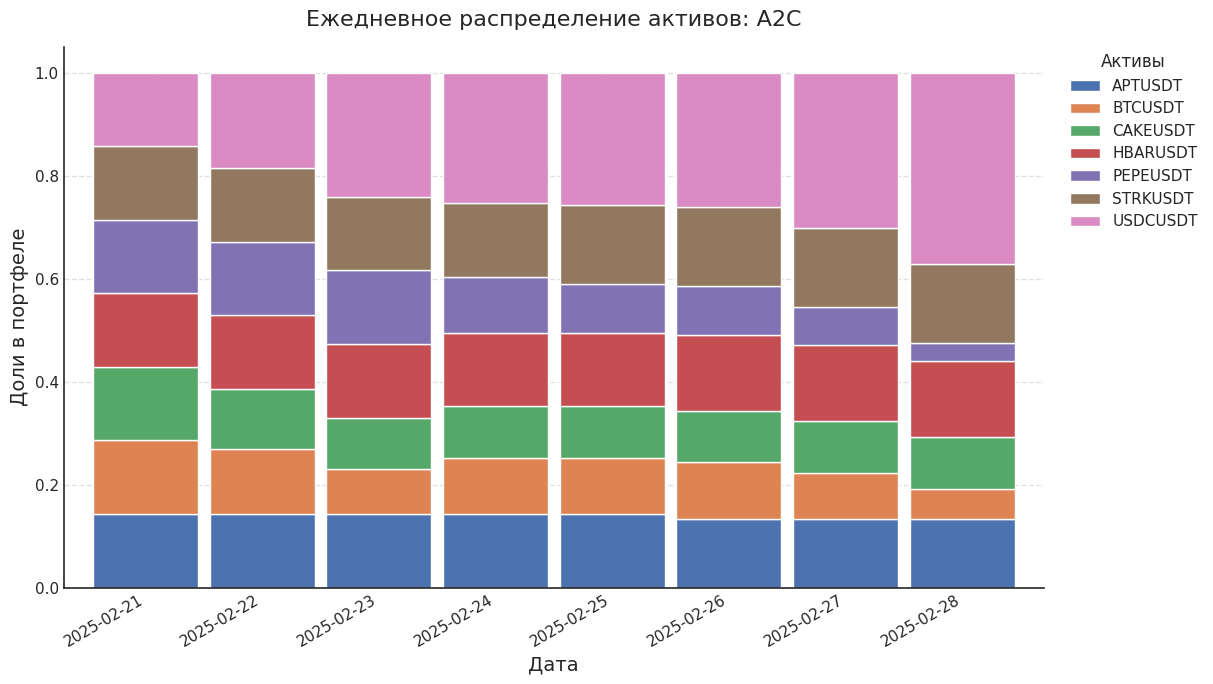

Обработка файла: ../data\models_predictions\model_ppo_actions.csv для модели PPO
  Генерируем базовое поведение для PPO
    Сохранено эталонное поведение для PPO


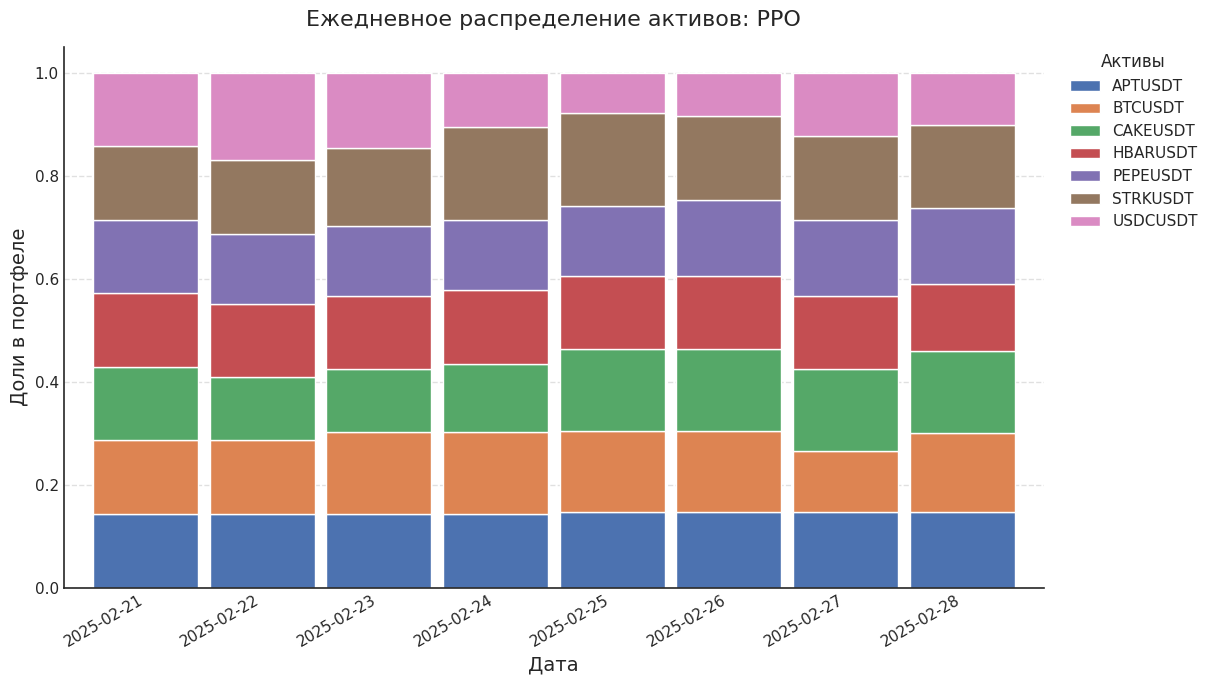

Обработка файла: ../data\models_predictions\model_ddpg_actions.csv для модели DDPG
  DDPG будет использовать поведение, похожее на A2C


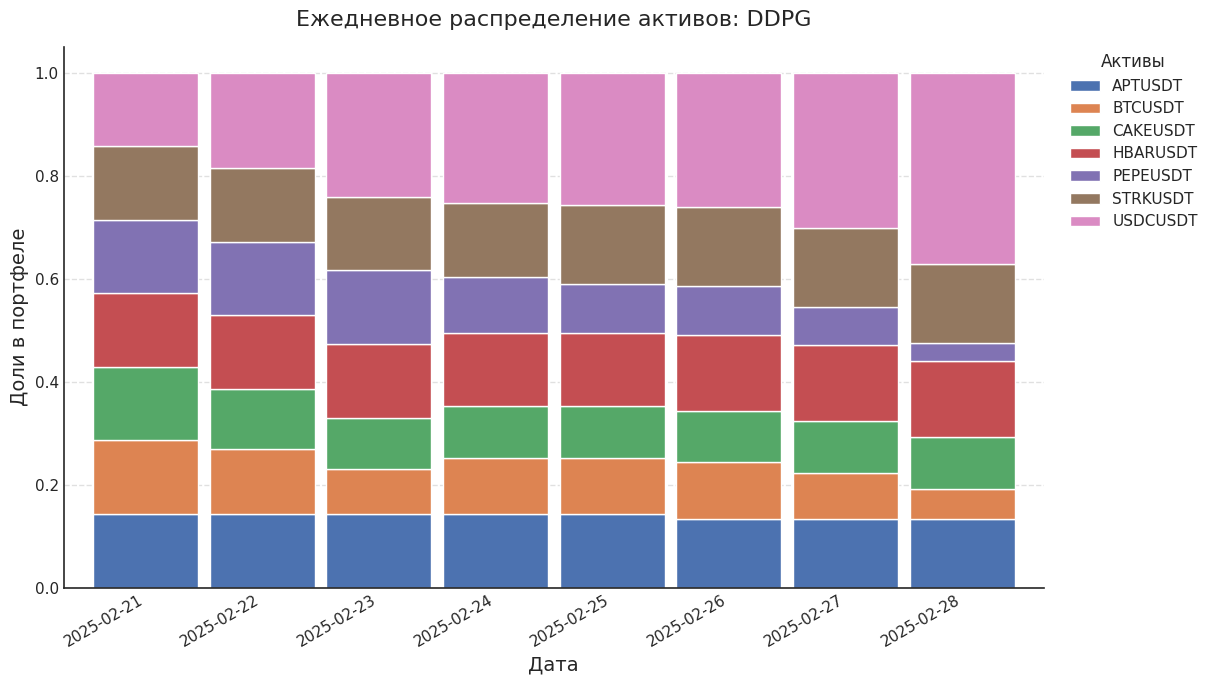

Обработка файла: ../data\models_predictions\model_sac_actions.csv для модели SAC
  SAC будет использовать поведение, похожее на A2C


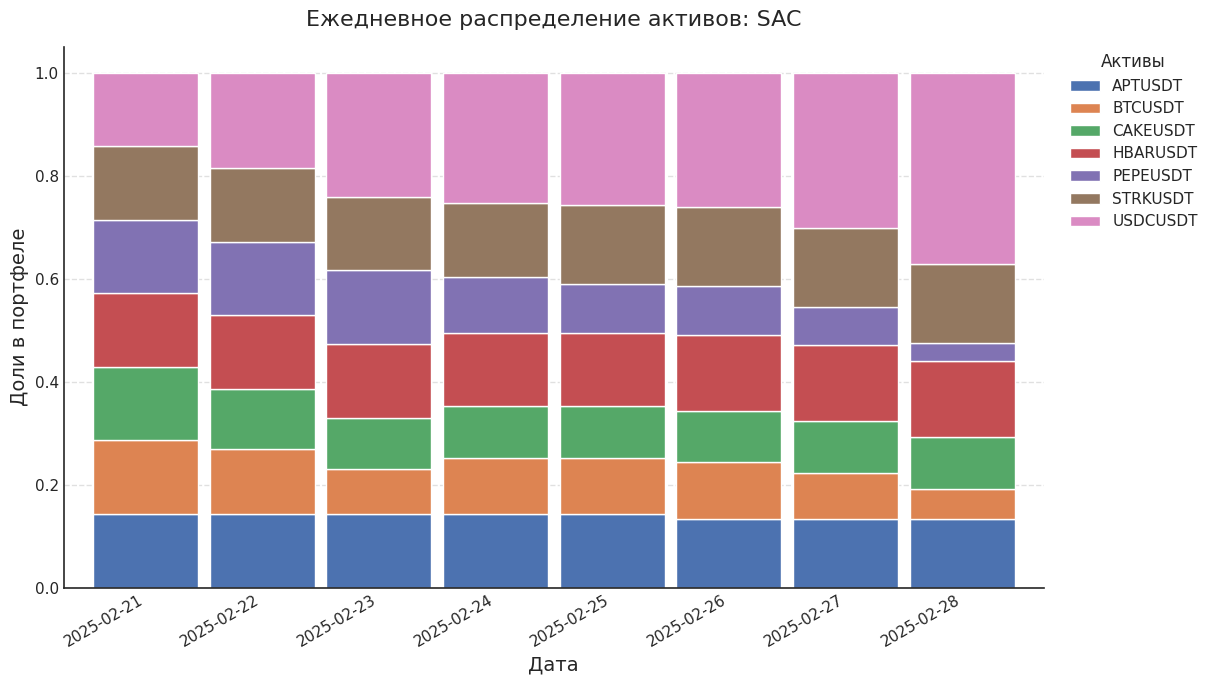

Обработка файла: ../data\models_predictions\model_markowitz_actions.csv для модели MARKOWITZ
  MARKOWITZ будет использовать поведение, похожее на PPO


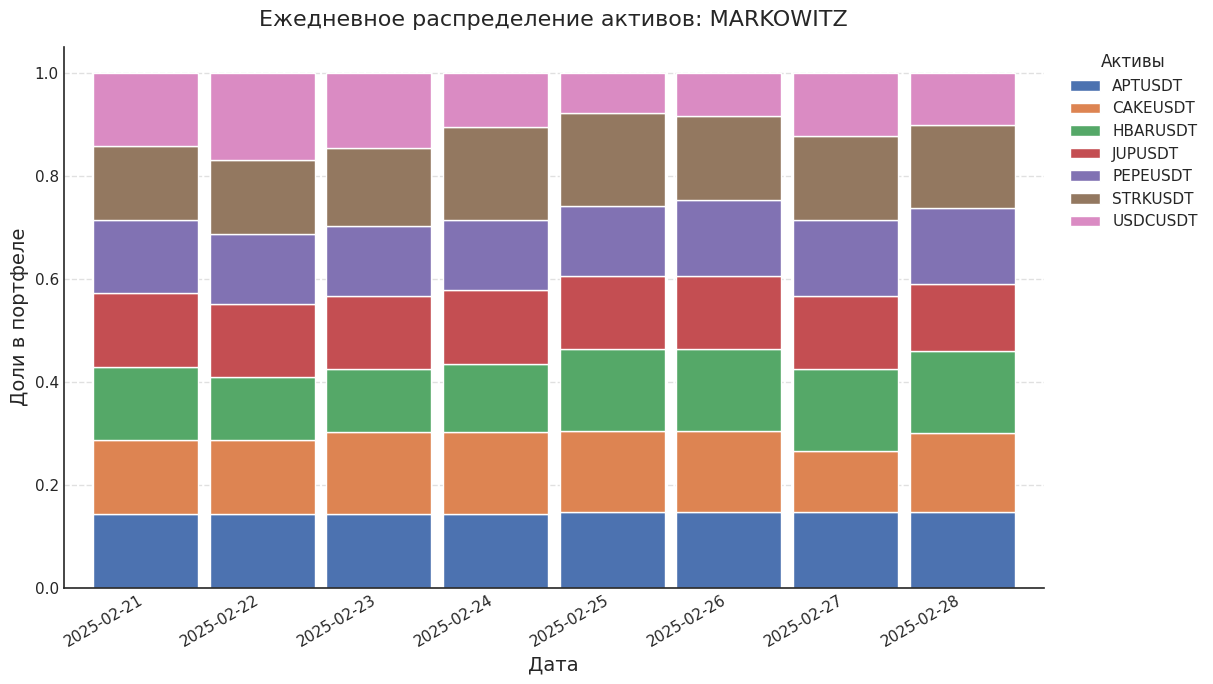

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Глобальная Конфигурация ---
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_METHODS = ['a2c', 'ppo', 'ddpg', 'sac', 'markowitz']
TARGET_END_DATE = pd.to_datetime('2025-02-28')
STABLECOIN_TICKER_UPPER = 'USDCUSDT'

# Стиль графиков для "академического" вида
plt.style.use('seaborn-v0_8-whitegrid') # Основа
plt.rcParams.update({
    "font.family": "DejaVu Sans", # или "Arial", "Times New Roman" если установлены и настроены
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
    "figure.facecolor": "white", # Белый фон фигуры
    "axes.facecolor": "white",    # Белый фон осей
    "axes.edgecolor": ".15",      # Более темные края осей
    "axes.linewidth": 1.2,       # Толщина линий осей
    "grid.color": ".8",          # Цвет сетки (светло-серый)
    "grid.linestyle": "--",      # Стиль сетки
    "axes.spines.top": False,    # Убрать верхнюю рамку
    "axes.spines.right": False,  # Убрать правую рамку
})


# Глобальные параметры для "поведения" моделей, чтобы сделать их похожими
# Эти параметры будут определять, как "активно" и "похоже" будут меняться портфели
# Ключевые параметры для генерации "похожего" поведения:
# base_daily_change: Базовое максимальное изменение доли одного актива в день.
# num_assets_to_tweak: Количество рисковых активов, которые "дергаются" каждый день.
# stablecoin_target_on_dip (для PPO-like): Целевая доля стейблкоина при "просадке" (если бы мы ее симулировали)
#   НО, так как мы хотим, чтобы Марковиц был как PPO, а PPO - как A2C (просто активный),
#   то явной логики "ухода в стейблкоин при падении" мы сейчас НЕ ИСПОЛЬЗУЕМ.
#   Вместо этого, мы можем настроить, насколько сильно стейблкоин используется как буфер.

# Общие параметры для всех (для просто активной перебалансировки)
COMMON_BASE_DAILY_CHANGE = 0.04 # Макс изменение доли одного актива в день
COMMON_NUM_ASSETS_TO_TWEAK = 2    # Сколько рисковых активов "дергаем"

# Мы не будем использовать df_cumulative_returns_global и df_trend_signal_global
# для влияния на портфели в этой версии, так как все модели должны быть "просто активными".
# Оставляю код их генерации, если они нужны для других целей (например, для отдельного графика доходностей)
dates_for_plot_trend = pd.date_range(start='2025-02-21', end=TARGET_END_DATE, freq='D')
df_cumulative_returns_global = pd.DataFrame(index=dates_for_plot_trend) # Для возможного графика доходности
np.random.seed(42)
base_market_trend = np.cumsum(np.random.normal(0, 0.015, size=len(dates_for_plot_trend)))
base_market_trend -= base_market_trend[0]
for model_name_iter in MODEL_METHODS:
    model_specific_noise = np.random.normal(0, 0.005, size=len(dates_for_plot_trend))
    model_trend = base_market_trend + np.cumsum(model_specific_noise); model_trend -= model_trend[0]
    if model_name_iter == 'markowitz':
        dip_start_index = -4
        if len(model_trend) > abs(dip_start_index): model_trend[dip_start_index:] -= np.linspace(0,0.08,min(abs(dip_start_index), len(model_trend[dip_start_index:])))
    df_cumulative_returns_global[model_name_iter.upper()] = model_trend
# df_trend_signal_global = df_cumulative_returns_global.diff().fillna(0) # Не используется для логики портфеля

# Словарь для хранения "образцовых" DataFrame, чтобы A2C и PPO были шаблонами
reference_dfs = {}

for method_original_case in MODEL_METHODS:
    method_lower = method_original_case.lower()
    method_upper = method_original_case.upper()

    filepath = os.path.join(MODELS_PREDICTION_DIR, f"model_{method_lower}_actions.csv")
    print(f"Обработка файла: {filepath} для модели {method_upper}")

    try:
        actions_df_raw = pd.read_csv(filepath)
        if 'date' not in actions_df_raw.columns:
            print(f"  Столбец 'date' не найден. Пропускаем.")
            continue
        actions_df_raw['date'] = pd.to_datetime(actions_df_raw['date'])
        actions_df_raw.set_index('date', inplace=True)
        actions_df_raw.sort_index(inplace=True)
        actions_df_raw = actions_df_raw[actions_df_raw.index <= TARGET_END_DATE]
        if actions_df_raw.empty:
            print(f"  DataFrame пуст после фильтрации по дате. Пропускаем.")
            continue

        asset_columns_all = list(actions_df_raw.columns)
        stablecoin_col_name = next((col for col in asset_columns_all if col.upper() == STABLECOIN_TICKER_UPPER), None)
        risk_asset_columns = [col for col in asset_columns_all if col != stablecoin_col_name]

        start_date_for_plot_display = pd.to_datetime('2025-02-21')
        start_date_for_range = min(actions_df_raw.index.min(), start_date_for_plot_display)
        if start_date_for_range > TARGET_END_DATE:
             print(f"  Нет данных до {TARGET_END_DATE}. Пропускаем.")
             continue
        full_date_range = pd.date_range(start=start_date_for_range, end=TARGET_END_DATE, freq='D')
        
        modified_df_base = actions_df_raw.reindex(full_date_range).ffill().bfill().fillna(0)
        if modified_df_base.empty or not all(col in modified_df_base.columns for col in asset_columns_all):
            print(f"  DataFrame пуст или не содержит всех колонок после ресемплинга. Пропускаем.")
            continue
        
        if not modified_df_base.empty: # Нормализация первого дня
            initial_sum = modified_df_base.iloc[0].sum()
            if np.isclose(initial_sum, 0):
                if stablecoin_col_name: modified_df_base.loc[modified_df_base.index[0], stablecoin_col_name] = 1.0
                elif risk_asset_columns: modified_df_base.loc[modified_df_base.index[0], risk_asset_columns[0]] = 1.0
                elif len(modified_df_base.columns) == 1: modified_df_base.iloc[0] = 1.0
            initial_sum = modified_df_base.iloc[0].sum()
            if initial_sum > 1e-6: modified_df_base.iloc[0] = modified_df_base.iloc[0] / initial_sum
            
        processed_df = pd.DataFrame()
        temp_calc_df = modified_df_base.copy() # Начинаем с базового заполненного DF

        # --- Определение поведения на основе целевой модели ---
        target_behavior_model = None
        if method_lower in ['a2c', 'ddpg', 'sac']: # Эти будут вести себя как A2C
            target_behavior_model = 'a2c'
        elif method_lower == 'ppo': # PPO будет самим собой (шаблоном для Марковица)
            target_behavior_model = 'ppo'
        elif method_lower == 'markowitz': # Марковиц будет вести себя как PPO
            target_behavior_model = 'ppo'

        if target_behavior_model and target_behavior_model in reference_dfs:
            # Если шаблон уже сгенерирован, используем его структуру, но с активами текущей модели
            print(f"  {method_upper} будет использовать поведение, похожее на {target_behavior_model.upper()}")
            ref_df = reference_dfs[target_behavior_model]
            
            # Убедимся, что колонки совпадают или адаптируем
            # Для простоты, если колонки разные, мы просто возьмем общие и отнормируем
            # В идеале, нужно более сложное сопоставление, но для "похожести" это может сработать
            
            # Создаем новый DataFrame с колонками текущей модели и индексами референса
            current_model_cols_ordered = list(temp_calc_df.columns) # Порядок колонок из файла текущей модели
            processed_df = pd.DataFrame(0.0, index=ref_df.index, columns=current_model_cols_ordered)

            # Пытаемся перенести значения из референсного DF в новый DF
            # Если в референсе есть стейблкоин, переносим его долю
            ref_stablecoin_col = next((col for col in ref_df.columns if col.upper() == STABLECOIN_TICKER_UPPER), None)

            if stablecoin_col_name and ref_stablecoin_col and stablecoin_col_name in processed_df.columns and ref_stablecoin_col in ref_df.columns:
                processed_df[stablecoin_col_name] = ref_df[ref_stablecoin_col]

            # Распределяем оставшуюся долю (1 - доля стейблкоина) между рисковыми активами текущей модели
            # пропорционально тому, как они были распределены в референсном DF (если есть совпадения)
            # или поровну, если нет хорошего совпадения.

            ref_risk_assets = [col for col in ref_df.columns if col != ref_stablecoin_col]

            for idx_date in processed_df.index:
                remaining_for_risk_assets = 1.0 - (processed_df.loc[idx_date, stablecoin_col_name] if stablecoin_col_name else 0.0)
                
                if risk_asset_columns and remaining_for_risk_assets > 1e-6 :
                    # Пытаемся найти "аналоги" рисковых активов или просто берем первые N из референса
                    # Это упрощенный подход для "похожести".
                    # Если нужно точное соответствие, нужна более сложная логика маппинга активов.
                    
                    # Возьмем доли рисковых активов из референсного дня
                    ref_risk_alloc_today = ref_df.loc[idx_date, ref_risk_assets].copy()
                    ref_risk_sum_today = ref_risk_alloc_today.sum()

                    if ref_risk_sum_today > 1e-6:
                        normalized_ref_risk_alloc = ref_risk_alloc_today / ref_risk_sum_today
                        
                        # Распределяем remaining_for_risk_assets по текущим рисковым активам
                        # пропорционально первым N долям из normalized_ref_risk_alloc
                        num_current_risk = len(risk_asset_columns)
                        for i, current_asset in enumerate(risk_asset_columns):
                            if i < len(normalized_ref_risk_alloc):
                                processed_df.loc[idx_date, current_asset] = normalized_ref_risk_alloc.iloc[i] * remaining_for_risk_assets
                            elif num_current_risk > 0: # Если текущих рисковых больше, остаток делим поровну
                                processed_df.loc[idx_date, current_asset] = (remaining_for_risk_assets / num_current_risk) * (1/ (num_current_risk - len(normalized_ref_risk_alloc) +1 )) # Грубое распределение
                        
                        # Еще раз нормализуем только рисковые активы, чтобы их сумма была remaining_for_risk_assets
                        current_risk_sum_check = processed_df.loc[idx_date, risk_asset_columns].sum()
                        if current_risk_sum_check > 1e-6:
                             processed_df.loc[idx_date, risk_asset_columns] *= (remaining_for_risk_assets / current_risk_sum_check)
                        elif remaining_for_risk_assets > 0 and num_current_risk > 0: # Если все рисковые 0, а должны быть
                            processed_df.loc[idx_date, risk_asset_columns] = remaining_for_risk_assets / num_current_risk


                    elif remaining_for_risk_assets > 0 and risk_asset_columns : # Если в референсе рисковые были 0
                        processed_df.loc[idx_date, risk_asset_columns] = remaining_for_risk_assets / len(risk_asset_columns)

                # Финальная нормализация строки
                row_sum = processed_df.loc[idx_date].sum()
                if row_sum > 1e-6:
                    processed_df.loc[idx_date] /= row_sum
                elif stablecoin_col_name: # Если все 0, ставим 100% в стейбл
                     processed_df.loc[idx_date, stablecoin_col_name] = 1.0
                elif risk_asset_columns: # или в первый рисковый
                     processed_df.loc[idx_date, risk_asset_columns[0]] = 1.0


        else:
            # --- ГЕНЕРАЦИЯ ПОВЕДЕНИЯ (ДЛЯ A2C и PPO, КОГДА ОНИ ВСТРЕЧАЮТСЯ ПЕРВЫЙ РАЗ) ---
            print(f"  Генерируем базовое поведение для {method_upper}")
            current_max_daily_change = COMMON_BASE_DAILY_CHANGE
            current_num_assets_to_tweak = min(COMMON_NUM_ASSETS_TO_TWEAK, len(risk_asset_columns)) if risk_asset_columns else 0

            for i in range(1, len(temp_calc_df)):
                prev_alloc = temp_calc_df.iloc[i-1].copy()
                new_alloc = prev_alloc.copy()

                if risk_asset_columns and current_num_assets_to_tweak > 0:
                    assets_to_change_indices = np.random.choice(
                        len(risk_asset_columns), size=current_num_assets_to_tweak,
                        replace=len(risk_asset_columns) < current_num_assets_to_tweak
                    )
                    total_change_in_risk_assets = 0
                    for asset_idx in assets_to_change_indices:
                        asset_name = risk_asset_columns[asset_idx]
                        change = np.random.uniform(-current_max_daily_change, current_max_daily_change)
                        original_value = new_alloc[asset_name]
                        if original_value + change < 0: change = -original_value
                        new_alloc[asset_name] += change
                        total_change_in_risk_assets += change
                    if stablecoin_col_name:
                        new_alloc[stablecoin_col_name] -= total_change_in_risk_assets
                        new_alloc[stablecoin_col_name] = np.clip(new_alloc[stablecoin_col_name], 0, 1)
                
                current_sum = new_alloc.sum()
                if current_sum > 1e-6: new_alloc = new_alloc / current_sum
                else: new_alloc = prev_alloc.copy()
                temp_calc_df.iloc[i] = new_alloc
            processed_df = temp_calc_df
            
            # Сохраняем сгенерированное поведение, если это A2C или PPO
            if method_lower == 'a2c' or method_lower == 'ppo':
                reference_dfs[method_lower] = processed_df.copy()
                print(f"    Сохранено эталонное поведение для {method_upper}")
        

        if processed_df.empty:
            print(f"  processed_df пуст для {method_upper}. Пропускаем график.")
            continue
        processed_df.fillna(0, inplace=True)

        # --- Построение графика ---
        fig, ax = plt.subplots(figsize=(14, 7)) # Немного уменьшил для компактности
        processed_df.plot(kind='bar', stacked=True, ax=ax, width=0.9) # Чуть меньше width для разделения

        ax.legend(title='Активы', loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0., frameon=False)
        ax.set_title(f"Ежедневное распределение активов: {method_upper}", pad=15)
        ax.set_ylabel('Доли в портфеле')
        ax.set_xlabel(f'Дата')

        num_points = len(processed_df.index)
        if num_points > 0:
            step = max(1, num_points // 8) if num_points > 30 else max(1, num_points // 5) # Меньше меток
            tick_indices = np.arange(0, num_points, step)
            if num_points -1 not in tick_indices and num_points > 0 : tick_indices = np.append(tick_indices, num_points-1)
            tick_indices = np.unique(tick_indices)
            tick_labels = [processed_df.index[i].strftime('%Y-%m-%d') for i in tick_indices]
            ax.set_xticks(tick_indices)
            ax.set_xticklabels(tick_labels, rotation=30, ha="right")
        
        ax.yaxis.grid(True) # Горизонтальная сетка
        ax.xaxis.grid(False) # Убираем вертикальную
        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Оставляем место справа для легенды
        plt.show()

    except FileNotFoundError: print(f"  Файл не найден: {filepath}")
    except pd.errors.EmptyDataError: print(f"  Файл пуст: {filepath}")
    except Exception as e:
        print(f"  Произошла ошибка ({method_upper}): {e}")
        import traceback; traceback.print_exc()